# Introducción

Este notebook forma parte del Trabajo de Fin de Máster en Inteligencia Artificial, desarrollado en colaboración con la fintech MytripleA. El objetivo principal es implementar un sistema de análisis de riesgo crediticio en escenarios con small data, integrando técnicas modernas de inteligencia artificial, generación de datos sintéticos y buenas prácticas de MLOps.

La motivación central de este proyecto surge de una necesidad real en el sector financiero: evaluar el riesgo crediticio de pequeñas y medianas empresas con volúmenes de datos limitados y desbalanceados. En estos casos, los enfoques tradicionales pierden precisión, por lo que se propone un pipeline automatizado, reproducible y explicable, capaz de entrenar modelos robustos incluso en condiciones adversas.

En este cuaderno y en el cuaderno llamado "EDA" se presentan las distintas fases del pipeline, que incluyen:

- Preprocesamiento y exploración de datos

- Generación de datos sintéticos con SMOTE y CTGAN

- Entrenamiento y evaluación de modelos con GridSearchCV

- Análisis de explicabilidad con SHAP

### Anonimización de datos

Este fragmento de código tiene como propósito verificar la unicidad de los identificadores de empresa en un dataset y, posteriormente, anonimizar dichos identificadores para proteger la confidencialidad de la información. Primero, se carga un archivo Parquet con datos empresariales y se analiza si la columna codigo_empresa contiene duplicados, mostrando el número de valores únicos y el total de registros. Luego, para garantizar la anonimización, se reemplazan los identificadores originales por un conjunto de IDs numéricos secuenciales generados mediante pd.factorize, eliminando así cualquier traza directa con los datos reales. Finalmente, se guarda el resultado como un nuevo archivo Parquet listo para su uso en contextos donde la privacidad de los datos es crítica, como en entornos regulatorios o colaboraciones externas.

In [ ]:
'''import pandas as pd

# Cargar el dataset
df = pd.read_parquet('companies_T.parquet')

# 1. Ver si hay valores duplicados en la columna 'codigo_empresa'
duplicados = df['codigo_empresa'].duplicated().any()
print("¿Hay valores duplicados en 'codigo_empresa'? ->", duplicados)

# Ver cuántos valores únicos hay
print("Valores únicos:", df['codigo_empresa'].nunique())
print("Total de registros:", len(df))

# 2. Anonimizar la columna 'codigo_empresa' asignando IDs secuenciales no rastreables
df['codigo_empresa'] = pd.factorize(df['codigo_empresa'])[0] + 1

# Guardar el nuevo 
df.to_parquet('companies_T_anon.parquet', index=False)

'''

Este bloque de código importa todas las librerías necesarias para construir un pipeline de credit scoring en un entorno de small data, integrando técnicas de aprendizaje automático, balanceo de clases y generación de datos sintéticos. Se incluyen librerías para: manipulación y preprocesamiento de datos (pandas, numpy, SimpleImputer, StandardScaler, MinMaxScaler), visualización (matplotlib), evaluación de modelos (confusion_matrix, classification_report, etc.), y modelado supervisado con múltiples algoritmos (LogisticRegression, RandomForestClassifier, XGBClassifier, etc.). También se incorporan herramientas específicas como CTGAN para generación de datos sintéticos, SMOTE para sobremuestreo, GridSearchCV para ajuste de hiperparámetros y joblib para guardar modelos. La inclusión de torch y random permite controlar la semilla aleatoria para garantizar la reproducibilidad en entornos experimentales. En conjunto, este bloque establece la base técnica para el desarrollo y experimentación de modelos robustos y explicables en entornos de datos reducidos.

In [2]:
from ctgan import CTGAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import os
from glob import glob
import re
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib
import random
import torch
import math


Este bloque de código agrupa funciones esenciales para el desarrollo de un pipeline robusto en contextos de small data y credit scoring, integrando generación de datos sintéticos, preprocesamiento, selección de variables, visualización y evaluación de modelos. En primer lugar, se fija una semilla global para garantizar reproducibilidad en experimentos con random, numpy y torch. La función generar_datos_ctgan permite ampliar datasets desbalanceados mediante CTGAN, combinando técnicas de imputación, codificación y escalado, y devolviendo un dataset enriquecido. Por otro lado, se incluyen funciones de visualización para representar matrices de confusión, curvas ROC y la importancia de variables, facilitando la interpretabilidad del modelo. Además, se provee una herramienta (generar_tabla_comparativa_f1) que resume y compara métricas de distintos modelos y escenarios. Las funciones preprocesar_datos y seleccionar_variables realizan un tratamiento sistemático del dataset: imputación, normalización, detección de outliers, y eliminación de variables con baja varianza o alta colinealidad, lo cual es crucial para evitar sobreajuste y mejorar la calidad de los modelos entrenados. En conjunto, este bloque constituye la base funcional y metodológica del pipeline de experimentación, siguiendo las buenas prácticas de MLOps.

In [3]:
random.seed(42)
np.random.seed(42)

def fijar_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def generar_datos_ctgan(X, y, target_col="target_bin", n_samples=300, epochs=300):
    fijar_seed(42)
    df_ctgan = X.reset_index(drop=True).copy()
    y = y.reset_index(drop=True)

    # Eliminar columnas datetime
    datetime_cols = df_ctgan.select_dtypes(include="datetime64").columns
    if len(datetime_cols) > 0:
        print(f"Eliminando columnas datetime: {list(datetime_cols)}")
        df_ctgan.drop(columns=datetime_cols, inplace=True)

    # Imputar nulos
    imputer = SimpleImputer(strategy="median")
    df_ctgan[df_ctgan.columns] = imputer.fit_transform(df_ctgan)

    # Añadir target
    df_ctgan[target_col] = y

    # Columnas categóricas
    discrete_cols = df_ctgan.select_dtypes(include='object').columns.tolist()
    if target_col not in discrete_cols:
        discrete_cols.append(target_col)

    # CTGAN
    ctgan = CTGAN(epochs=epochs)
    ctgan.fit(df_ctgan, discrete_columns=discrete_cols)

    synthetic_data = ctgan.sample(n_samples)
    synthetic_data[target_col] = synthetic_data[target_col].round().fillna(0).astype(int)

    print("Distribución de clase sintética:")
    print(synthetic_data[target_col].value_counts())

    df_combined = pd.concat([df_ctgan, synthetic_data], ignore_index=True)
    X_combined = df_combined.drop(columns=[target_col])
    y_combined = df_combined[target_col].fillna(0).astype(int)

    # One-hot encoding y escalado
    X_combined = pd.get_dummies(X_combined, drop_first=True)
    scaler = StandardScaler()
    X_combined_scaled = scaler.fit_transform(X_combined)

    return X_combined_scaled, y_combined

def plot_confusion_matrix(y_true, y_pred, model_name, suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión - {model_name}")
    plt.show()


from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_prob, model_name, suffix=""):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f"Curva ROC - {model_name}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.show()


def plot_feature_importance(model, feature_names, model_name, suffix=""):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        sorted_idx = importances.argsort()[::-1]
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(importances)), importances[sorted_idx])
        plt.xticks(range(len(importances)), 
                   [feature_names[i] for i in sorted_idx], 
                   rotation=90)
        plt.title(f"Importancia de Variables - {model_name}")
        plt.tight_layout()
        plt.show()


def generar_tabla_comparativa_f1(lista_resultados):
    import pandas as pd

    df_all = pd.DataFrame(lista_resultados)

    if df_all.empty:
        print("No hay resultados para mostrar.")
        return None

    tabla = df_all.pivot_table(
        index="modelo",
        columns="dataset",
        values="f1_score",
        aggfunc="max"
    )

    display(tabla.round(2))

    print("\n Mejor modelo por dataset:")
    for dataset in tabla.columns:
        mejor_modelo = tabla[dataset].idxmax()
        f1 = tabla[dataset].max()
        print(f"- {dataset}: {mejor_modelo} (F1 = {f1:.2f})")

    mejor_global = tabla.stack().idxmax()
    mejor_modelo_global, mejor_dataset_global = mejor_global
    f1_global = tabla.loc[mejor_modelo_global, mejor_dataset_global]
    print(f"\n Mejor modelo global: {mejor_modelo_global} con {mejor_dataset_global} (F1 = {f1_global:.2f})")

    return tabla


def preprocesar_datos(
    df,
    eliminar_columnas_alta_nulos=True,
    umbral_nulos=0.65,
    imputacion=True,
    estrategia_imputacion='median',
    tratar_outliers=True,
    metodo_outliers='IQR',
    escalar=True,
    metodo_escalado='standard'
):
    df = df.copy()

    df['grade_code'] = pd.to_numeric(df['grade_code'], errors='coerce')
    df = df[df['grade_code'].notna()]
    df['target_bin'] = df['grade_code'].astype(int).apply(lambda x: 1 if x >= 7 else 0)

    if 'fecha_constitucion' in df.columns:
        df = df.drop(columns='fecha_constitucion')

    if 'codigo_empresa' in df.columns:
        df = df.drop(columns='codigo_empresa')

    if eliminar_columnas_alta_nulos:
        df = df.loc[:, df.isnull().mean() < umbral_nulos]

    if imputacion:
        imp = SimpleImputer(strategy=estrategia_imputacion)
        cols_target = ['grade_code', 'target_bin']
        numeric_cols = df.select_dtypes(include=['number']).columns
        numeric_cols = [col for col in numeric_cols if col not in cols_target]
        df[numeric_cols] = imp.fit_transform(df[numeric_cols])

    if tratar_outliers:
        numeric_cols = df.select_dtypes(include=['number']).columns
        numeric_cols = [col for col in numeric_cols if col not in ['grade_code', 'target_bin']]
        for col in numeric_cols:
            if metodo_outliers == 'IQR':
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower = Q1 - 1.5 * IQR
                upper = Q3 + 1.5 * IQR
                df[col] = np.clip(df[col], lower, upper)
            elif metodo_outliers == 'zscore':
                z = (df[col] - df[col].mean()) / df[col].std()
                df[col] = np.where(z > 3, df[col].mean(), df[col])
                df[col] = np.where(z < -3, df[col].mean(), df[col])

    if escalar:
        scaler = StandardScaler() if metodo_escalado == 'standard' else MinMaxScaler()
        numeric_cols = df.select_dtypes(include=['number']).columns
        numeric_cols = [col for col in numeric_cols if col not in ['grade_code', 'target_bin']]
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df


def seleccionar_variables(df, target_col, umbral_varianza=0.01, umbral_correlacion=0.95):
    df = df.copy()

    posibles_targets = ['grade_code', 'target_bin', 'grade_group']
    posibles_targets.remove(target_col)
    df = df.drop(columns=[col for col in posibles_targets if col in df.columns])

    columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col not in columnas_numericas:
        columnas_numericas.append(target_col)
    df = df[columnas_numericas]

    selector = VarianceThreshold(threshold=umbral_varianza)
    features = df.drop(columns=[target_col])
    selector.fit(features)
    columnas_baja_varianza = features.columns[~selector.get_support()]
    print(f"Eliminando por baja varianza: {list(columnas_baja_varianza)}")
    df = df.drop(columns=columnas_baja_varianza)

    corr_matrix = df.drop(columns=[target_col]).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    columnas_alta_correlacion = [col for col in upper.columns if any(upper[col] > umbral_correlacion)]
    print(f"Eliminando por alta correlacion: {columnas_alta_correlacion}")
    df = df.drop(columns=columnas_alta_correlacion)

    return df


Este bloque constituye el núcleo experimental del pipeline de evaluación de modelos en escenarios de small data. La función entrenar_modelos se encarga de entrenar y comparar múltiples algoritmos de clasificación supervisada (como Logistic Regression, Random Forest, XGBoost o MLP) usando GridSearchCV para la optimización de hiperparámetros y validación cruzada. Internamente, se separan los datos en entrenamiento y prueba, se entrena cada modelo, se calculan métricas clave (accuracy, precision, recall, f1-score) y se generan gráficos de evaluación (matriz de confusión, curva ROC, importancia de variables) para cada caso, facilitando la interpretación y comparación visual en notebooks.

Además, se contempla el uso de distintas variantes del conjunto de datos: datos originales, sobremuestreados con SMOTE, generados con CTGAN y combinaciones de ambos métodos. Esto permite analizar el impacto real de las técnicas de enriquecimiento en el rendimiento de los modelos. La ejecución principal (if _name_ == "_main_") carga el dataset anonimizado, realiza el preprocesamiento y la selección de variables, y ejecuta el pipeline completo en todos los escenarios mencionados. Se genera una tabla resumen de resultados mediante generar_tabla_comparativa_f1, que destaca el mejor modelo por escenario y el mejor modelo global. Esta estructura modular y automatizada está alineada con buenas prácticas de MLOps, y permite iterar, escalar y analizar el sistema con trazabilidad completa.

In [4]:
def entrenar_modelos(X, y, dataset_name='Original', scoring='f1', test_size=0.2, random_state=42):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

    parametros_modelos = {
        'LogisticRegression': {'C': [0.1, 1.0, 10.0]},
        'RandomForest': {'n_estimators': [100, 200], 'max_depth': [None, 10]},
        'XGBoost': {'n_estimators': [100, 200], 'max_depth': [3, 6]},
        'GradientBoosting': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05]},
        'KNN': {'n_neighbors': [3, 5, 7]},
        'SVC': {'C': [0.1, 1.0], 'kernel': ['linear', 'rbf']},
        'NaiveBayes': {},
        'MLP': {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.001]}
    }

    modelos = {
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
        'RandomForest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(eval_metric='logloss',random_state=42),
        'GradientBoosting': GradientBoostingClassifier(random_state=42),
        'KNN': KNeighborsClassifier(),
        'SVC': SVC(probability=True, random_state=42),
        'NaiveBayes': GaussianNB(),
        'MLP': MLPClassifier(max_iter=1000, random_state=42)
    }

    resultados = []

    for nombre, modelo in modelos.items():
        print(f"\n Entrenando {nombre} con {dataset_name}")
        try:
            params = parametros_modelos.get(nombre, {})
            grid = GridSearchCV(modelo, params, cv=3, scoring=scoring, n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            y_pred = best_model.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)

            resultados.append({
                "dataset": dataset_name,
                "modelo": nombre,
                "accuracy": acc,
                "f1_score": f1,
                "precision": prec,
                "recall": recall
            })

            # Probabilidades para ROC
            if hasattr(best_model, "predict_proba"):
                y_proba = best_model.predict_proba(X_test)[:, 1]
            elif hasattr(best_model, "decision_function"):
                y_proba = best_model.decision_function(X_test)
            else:
                y_proba = None

            # Gráficos en notebook
            plot_confusion_matrix(y_test, y_pred, nombre)
            if y_proba is not None:
                plot_roc_curve(y_test, y_proba, nombre)
            if hasattr(best_model, "feature_importances_"):
                plot_feature_importance(best_model, X.columns, nombre)

            print(classification_report(y_test, y_pred))

        except Exception as e:
            print(f" Error con {nombre}: {repr(e)}")

    # Mostrar resultados en DataFrame
    df_resultados = pd.DataFrame(resultados)
    display(df_resultados.sort_values(by="f1_score", ascending=False))

    # Mejor modelo del dataset
    mejor_resultado = max(resultados, key=lambda x: x["f1_score"])
    print(f"\n Mejor modelo para {dataset_name}: {mejor_resultado['modelo']} (F1={mejor_resultado['f1_score']:.2f})")

    return resultados




Eliminando por baja varianza: ['cash_flow_antes_var']
Eliminando por alta correlacion: []
 Datos originales

 Entrenando LogisticRegression con Original


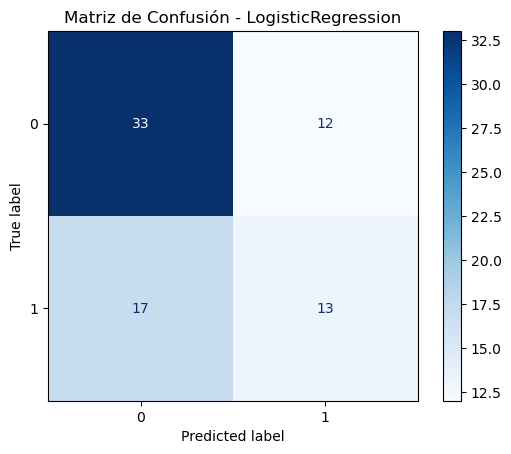

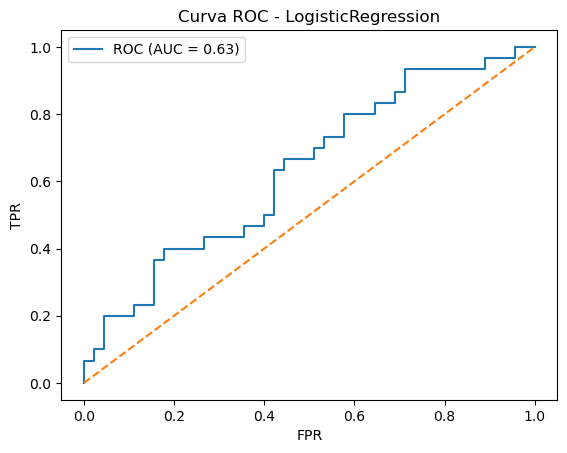

              precision    recall  f1-score   support

           0       0.66      0.73      0.69        45
           1       0.52      0.43      0.47        30

    accuracy                           0.61        75
   macro avg       0.59      0.58      0.58        75
weighted avg       0.60      0.61      0.61        75


 Entrenando RandomForest con Original


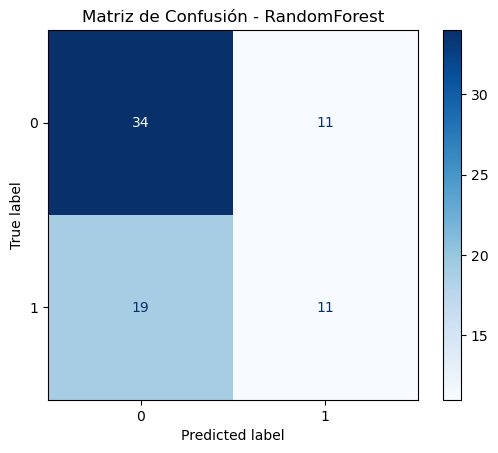

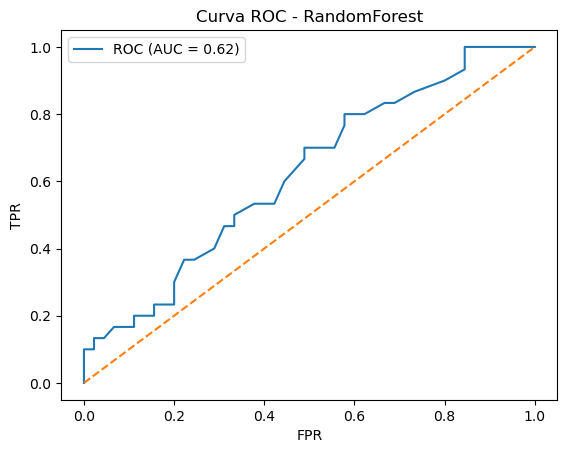

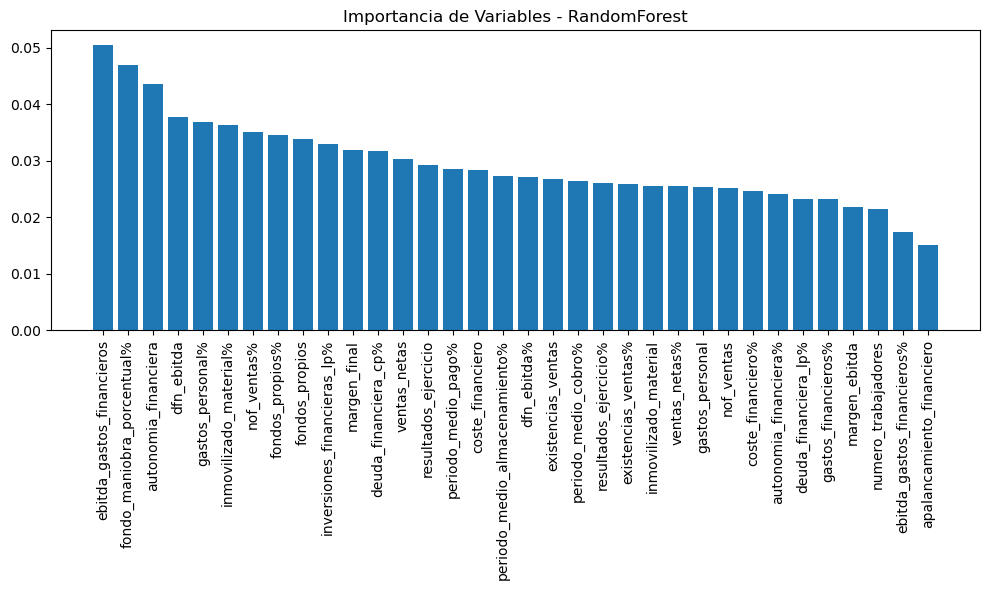

              precision    recall  f1-score   support

           0       0.64      0.76      0.69        45
           1       0.50      0.37      0.42        30

    accuracy                           0.60        75
   macro avg       0.57      0.56      0.56        75
weighted avg       0.58      0.60      0.59        75


 Entrenando XGBoost con Original


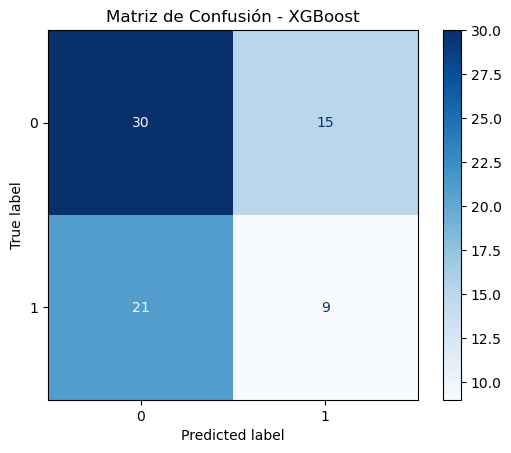

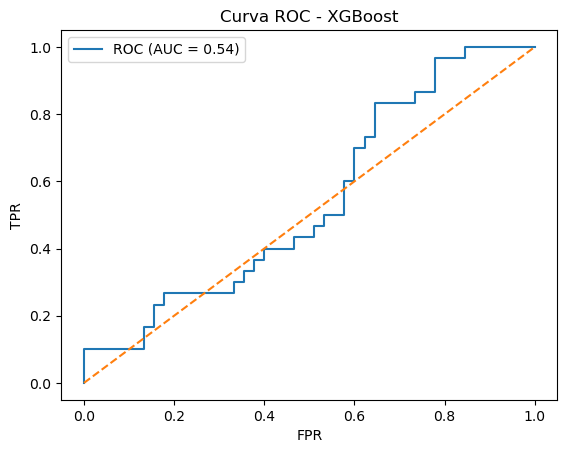

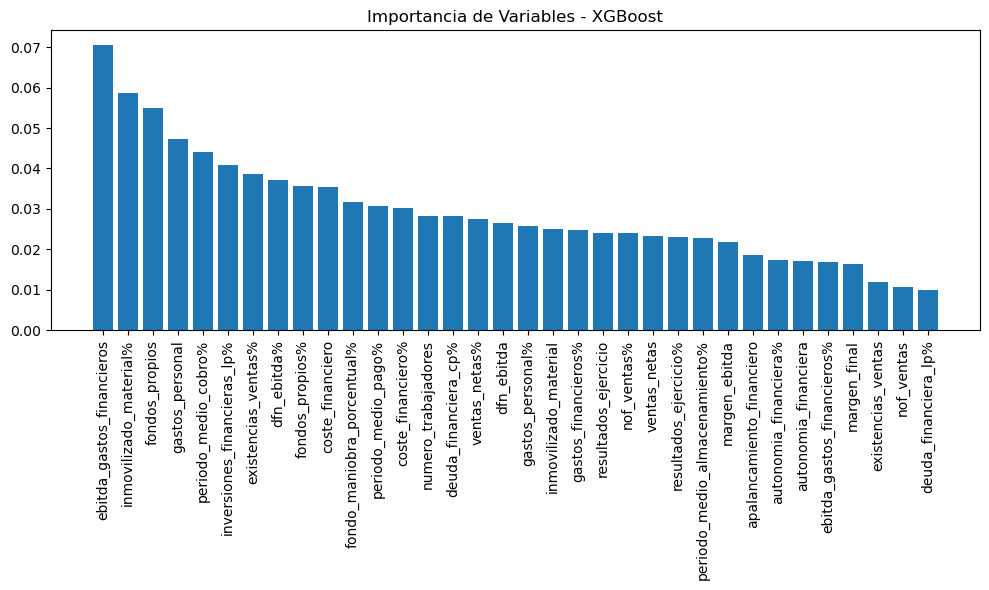

              precision    recall  f1-score   support

           0       0.59      0.67      0.62        45
           1       0.38      0.30      0.33        30

    accuracy                           0.52        75
   macro avg       0.48      0.48      0.48        75
weighted avg       0.50      0.52      0.51        75


 Entrenando GradientBoosting con Original


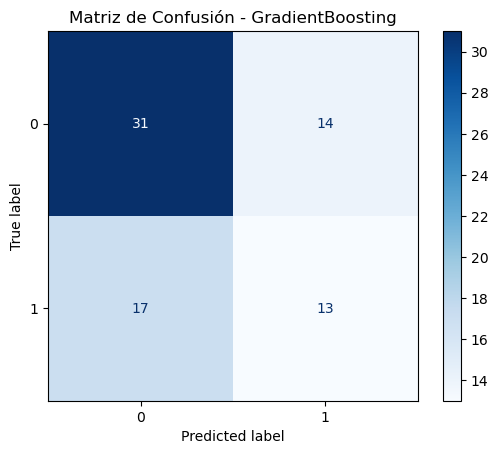

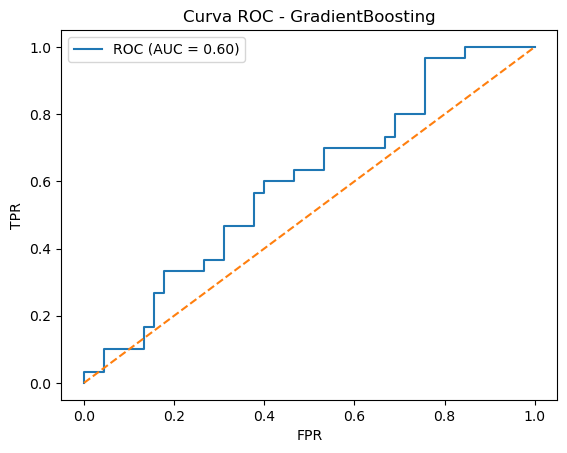

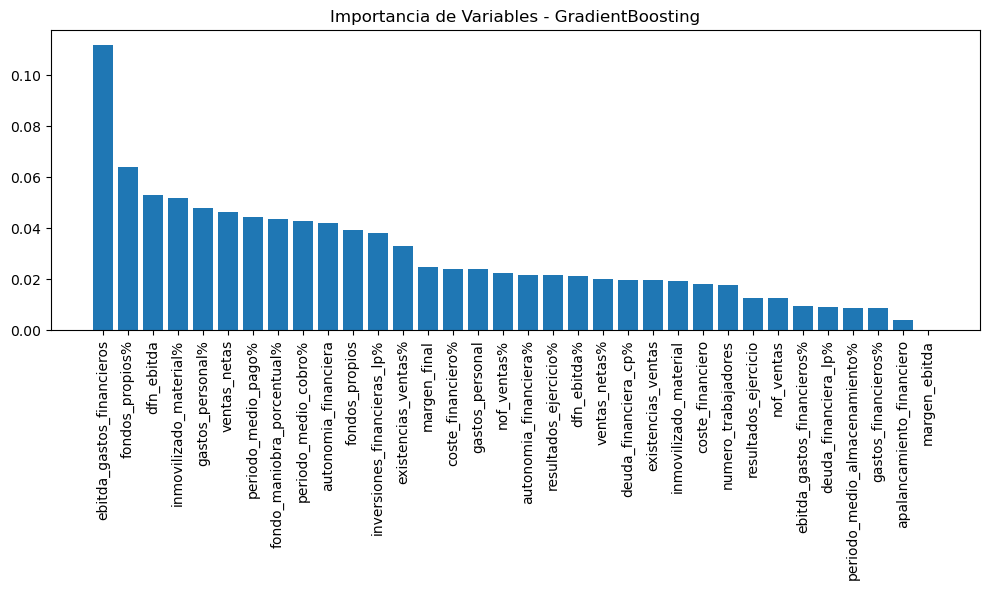

              precision    recall  f1-score   support

           0       0.65      0.69      0.67        45
           1       0.48      0.43      0.46        30

    accuracy                           0.59        75
   macro avg       0.56      0.56      0.56        75
weighted avg       0.58      0.59      0.58        75


 Entrenando KNN con Original


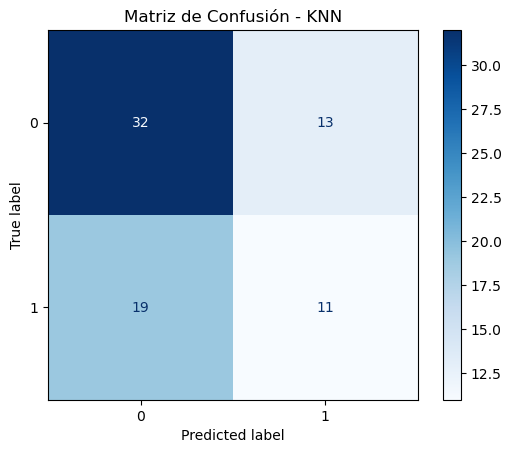

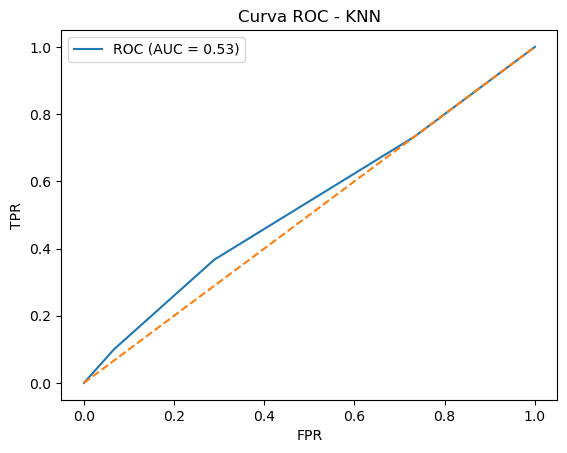

              precision    recall  f1-score   support

           0       0.63      0.71      0.67        45
           1       0.46      0.37      0.41        30

    accuracy                           0.57        75
   macro avg       0.54      0.54      0.54        75
weighted avg       0.56      0.57      0.56        75


 Entrenando SVC con Original


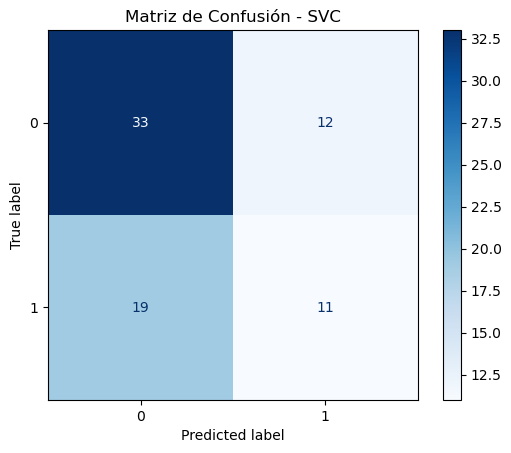

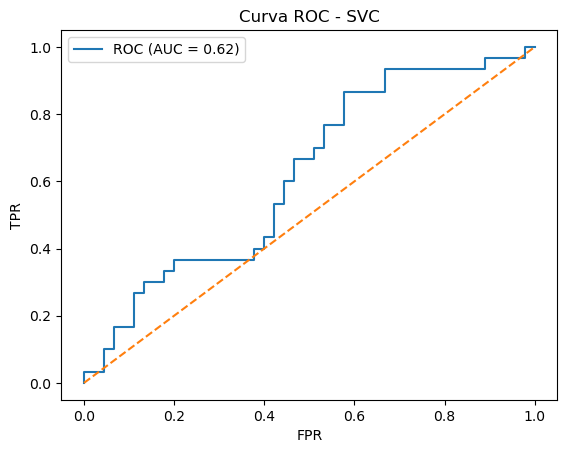

              precision    recall  f1-score   support

           0       0.63      0.73      0.68        45
           1       0.48      0.37      0.42        30

    accuracy                           0.59        75
   macro avg       0.56      0.55      0.55        75
weighted avg       0.57      0.59      0.57        75


 Entrenando NaiveBayes con Original


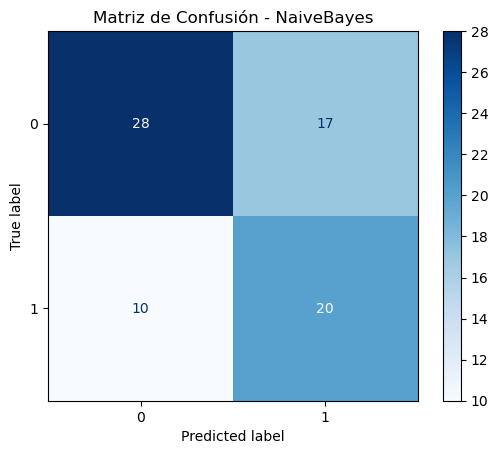

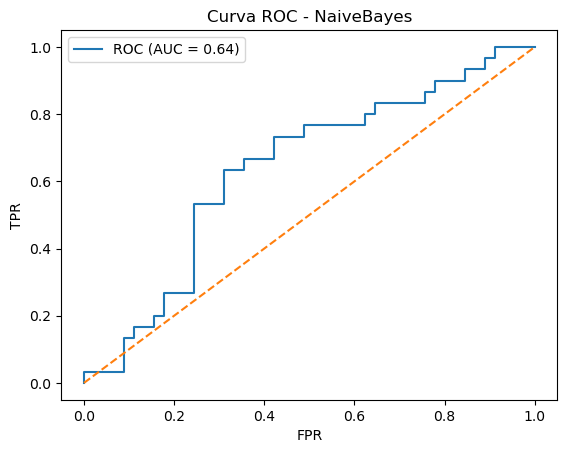

              precision    recall  f1-score   support

           0       0.74      0.62      0.67        45
           1       0.54      0.67      0.60        30

    accuracy                           0.64        75
   macro avg       0.64      0.64      0.64        75
weighted avg       0.66      0.64      0.64        75


 Entrenando MLP con Original


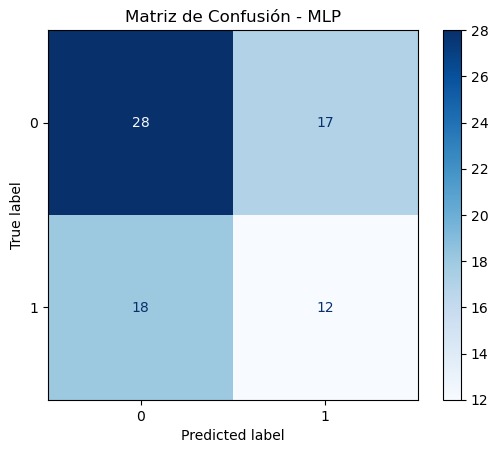

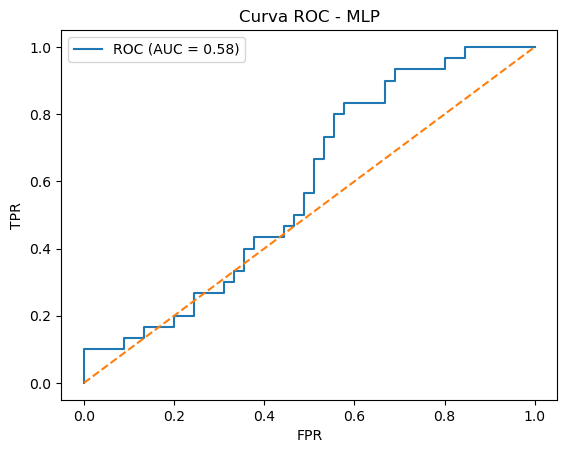

              precision    recall  f1-score   support

           0       0.61      0.62      0.62        45
           1       0.41      0.40      0.41        30

    accuracy                           0.53        75
   macro avg       0.51      0.51      0.51        75
weighted avg       0.53      0.53      0.53        75



dataset              modelo  accuracy  f1_score  precision    recall
6  Original          NaiveBayes  0.640000  0.597015   0.540541  0.666667
0  Original  LogisticRegression  0.613333  0.472727   0.520000  0.433333
3  Original    GradientBoosting  0.586667  0.456140   0.481481  0.433333
1  Original        RandomForest  0.600000  0.423077   0.500000  0.366667
5  Original                 SVC  0.586667  0.415094   0.478261  0.366667
4  Original                 KNN  0.573333  0.407407   0.458333  0.366667
7  Original                 MLP  0.533333  0.406780   0.413793  0.400000
2  Original             XGBoost  0.520000  0.333333   0.375000  0.300000


 Mejor modelo para Original: NaiveBayes (F1=0.60)
 Datos con SMOTE

 Entrenando LogisticRegression con SMOTE


`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.


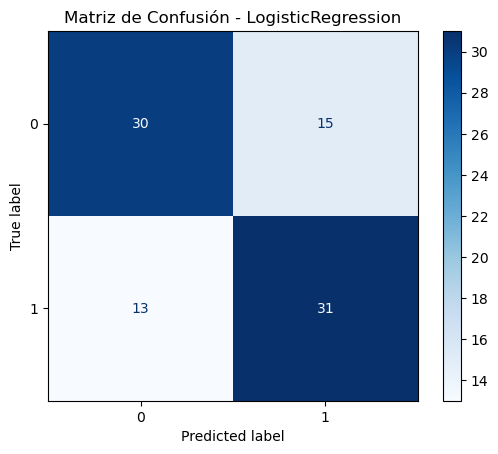

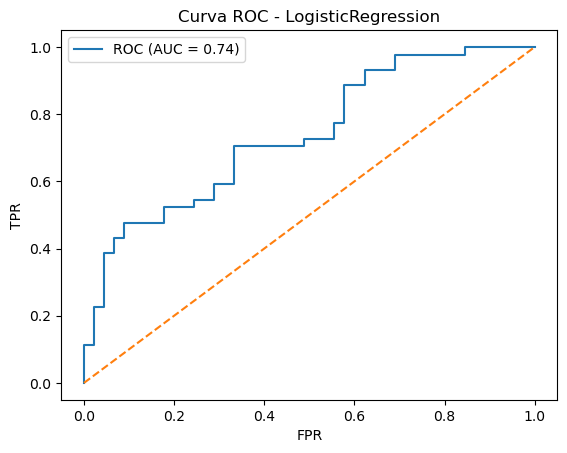

              precision    recall  f1-score   support

           0       0.70      0.67      0.68        45
           1       0.67      0.70      0.69        44

    accuracy                           0.69        89
   macro avg       0.69      0.69      0.69        89
weighted avg       0.69      0.69      0.69        89


 Entrenando RandomForest con SMOTE


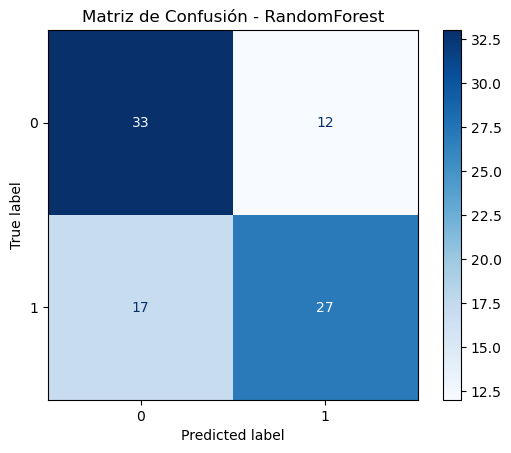

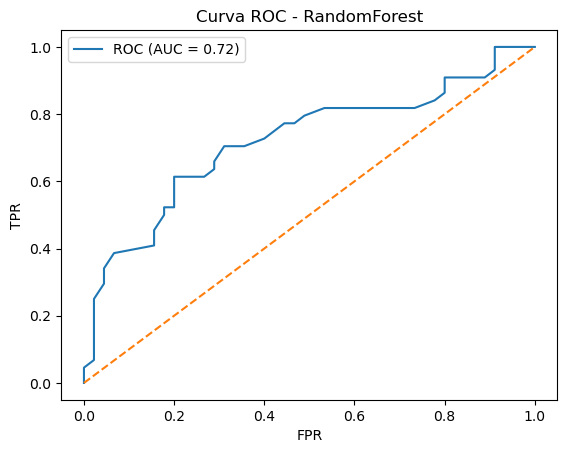

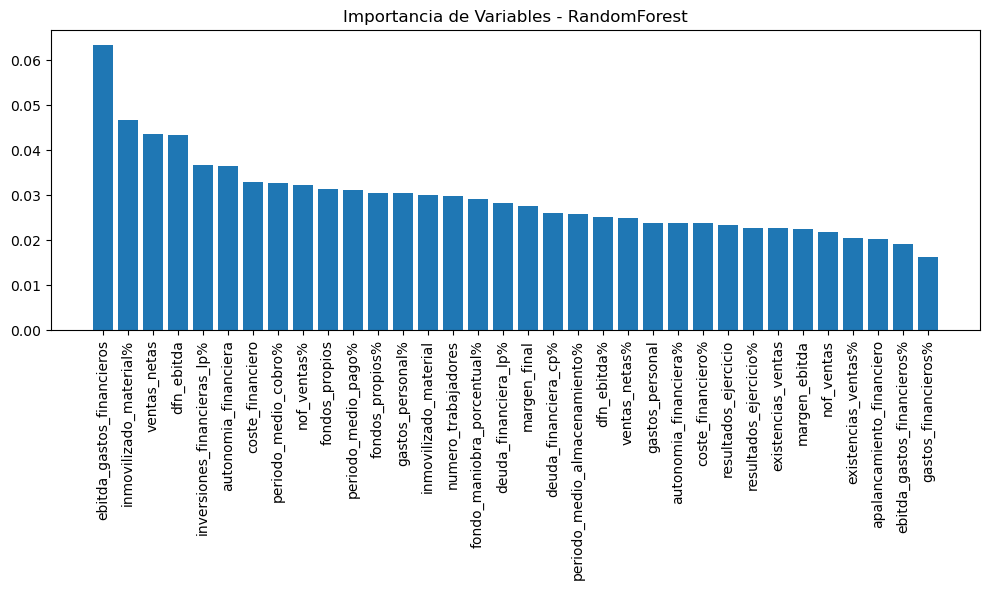

              precision    recall  f1-score   support

           0       0.66      0.73      0.69        45
           1       0.69      0.61      0.65        44

    accuracy                           0.67        89
   macro avg       0.68      0.67      0.67        89
weighted avg       0.68      0.67      0.67        89


 Entrenando XGBoost con SMOTE


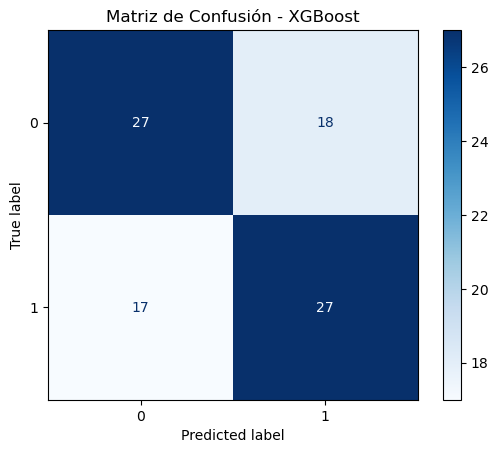

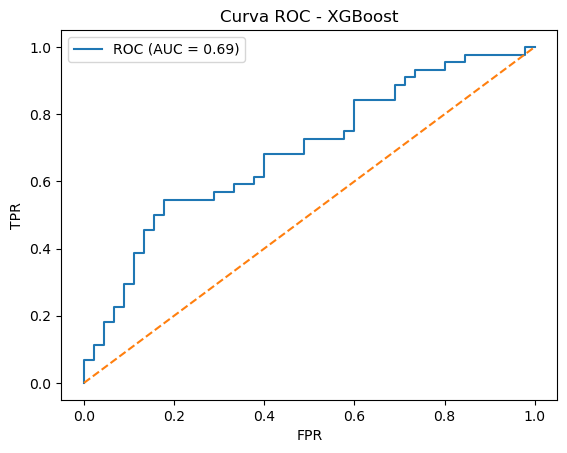

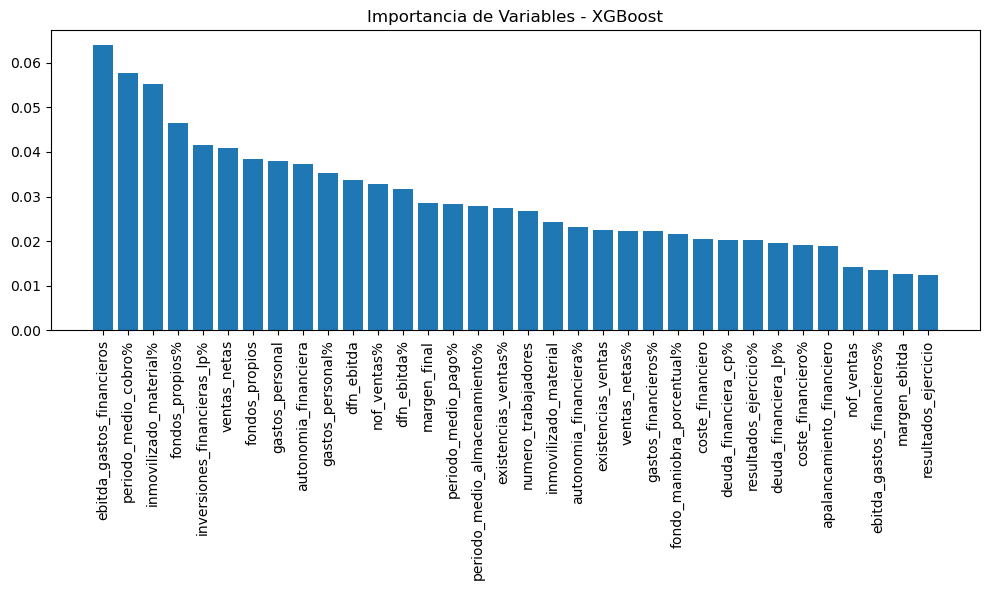

              precision    recall  f1-score   support

           0       0.61      0.60      0.61        45
           1       0.60      0.61      0.61        44

    accuracy                           0.61        89
   macro avg       0.61      0.61      0.61        89
weighted avg       0.61      0.61      0.61        89


 Entrenando GradientBoosting con SMOTE


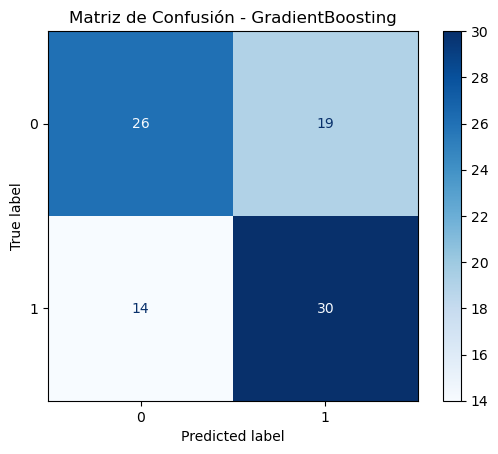

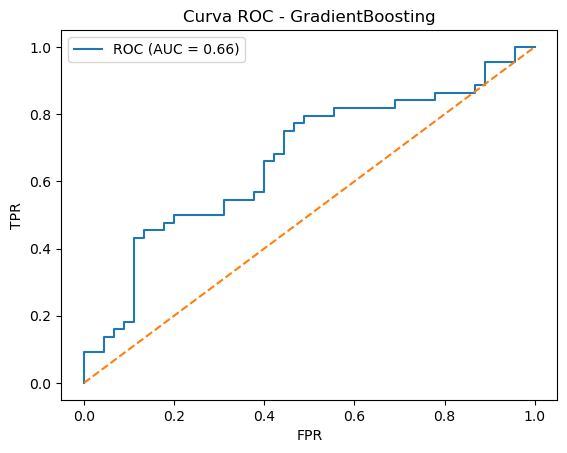

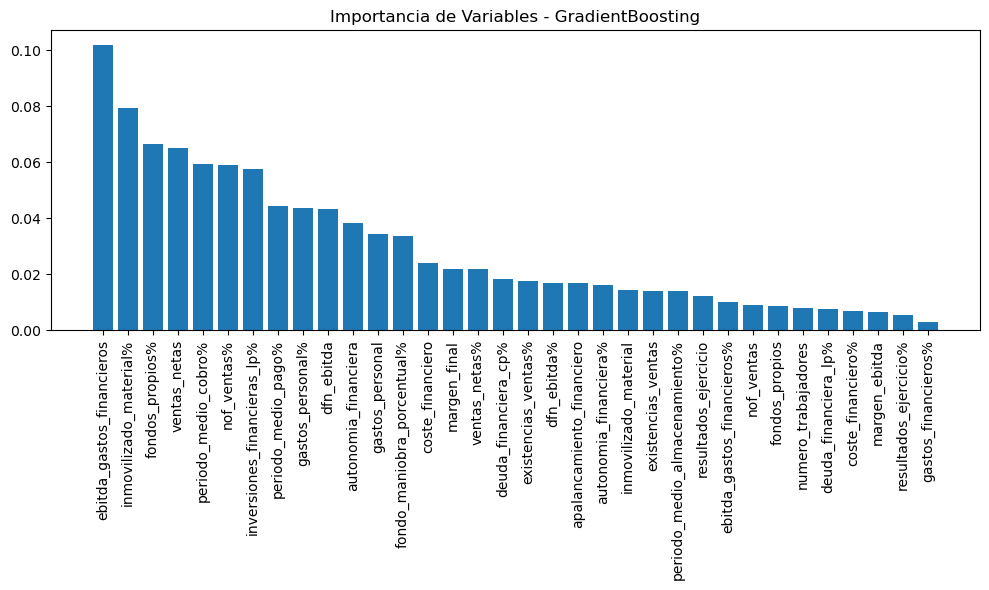

              precision    recall  f1-score   support

           0       0.65      0.58      0.61        45
           1       0.61      0.68      0.65        44

    accuracy                           0.63        89
   macro avg       0.63      0.63      0.63        89
weighted avg       0.63      0.63      0.63        89


 Entrenando KNN con SMOTE


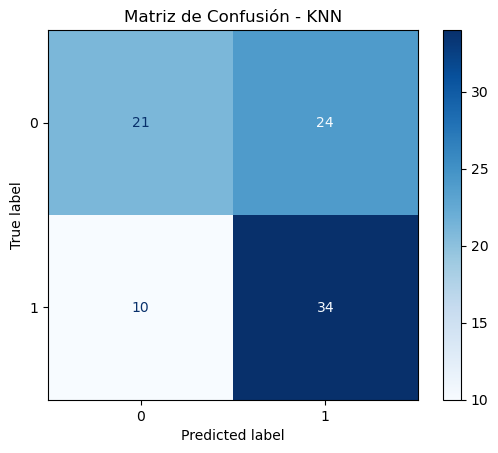

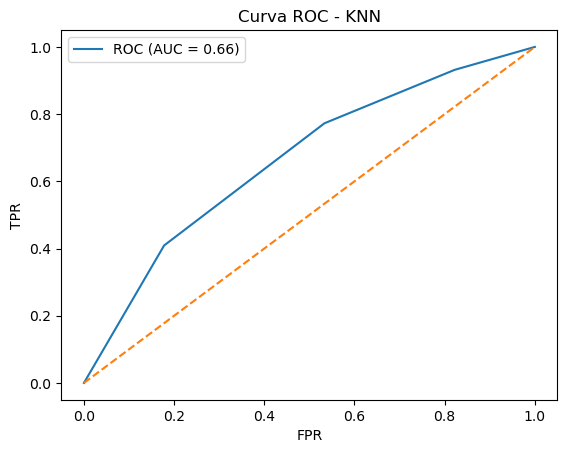

              precision    recall  f1-score   support

           0       0.68      0.47      0.55        45
           1       0.59      0.77      0.67        44

    accuracy                           0.62        89
   macro avg       0.63      0.62      0.61        89
weighted avg       0.63      0.62      0.61        89


 Entrenando SVC con SMOTE


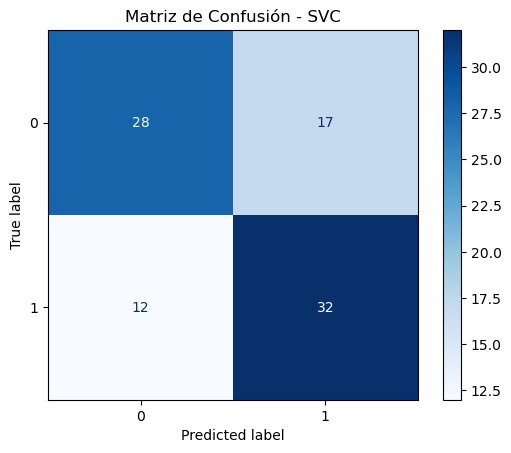

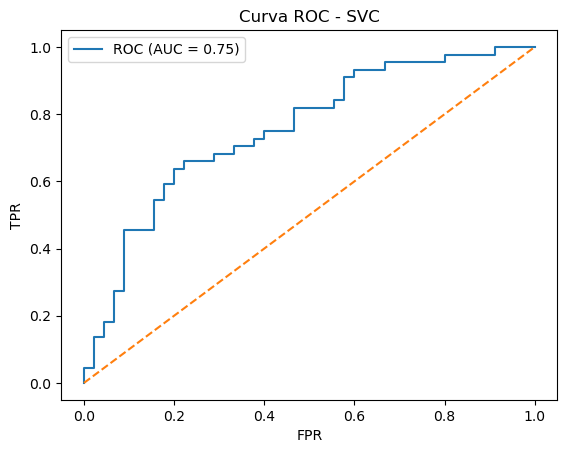

              precision    recall  f1-score   support

           0       0.70      0.62      0.66        45
           1       0.65      0.73      0.69        44

    accuracy                           0.67        89
   macro avg       0.68      0.67      0.67        89
weighted avg       0.68      0.67      0.67        89


 Entrenando NaiveBayes con SMOTE


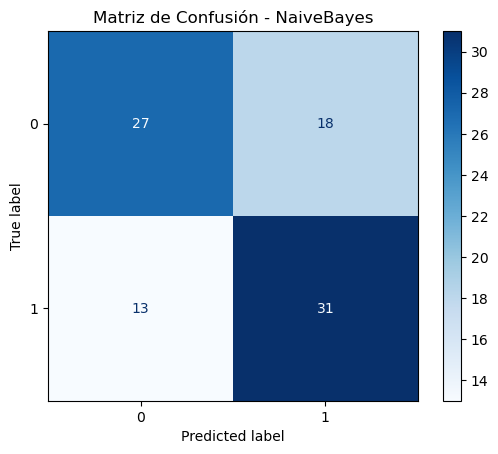

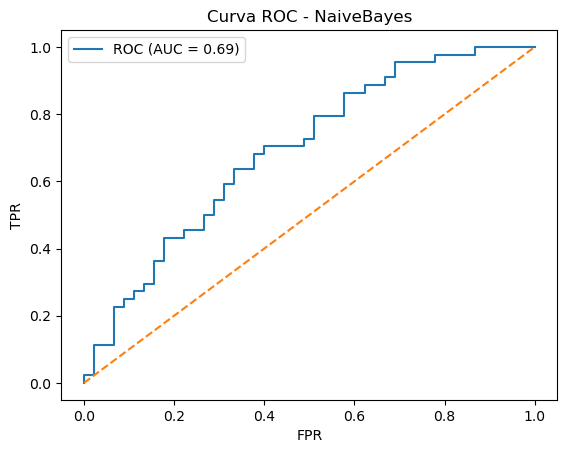

              precision    recall  f1-score   support

           0       0.68      0.60      0.64        45
           1       0.63      0.70      0.67        44

    accuracy                           0.65        89
   macro avg       0.65      0.65      0.65        89
weighted avg       0.65      0.65      0.65        89


 Entrenando MLP con SMOTE


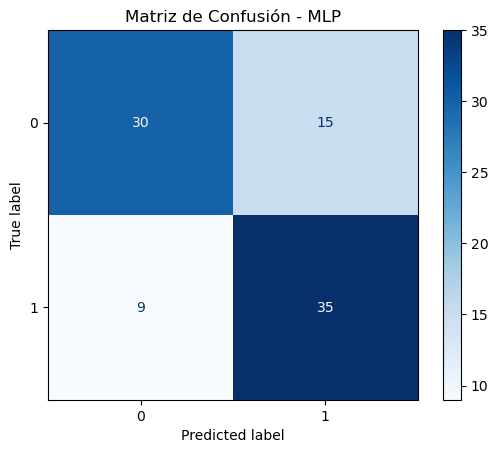

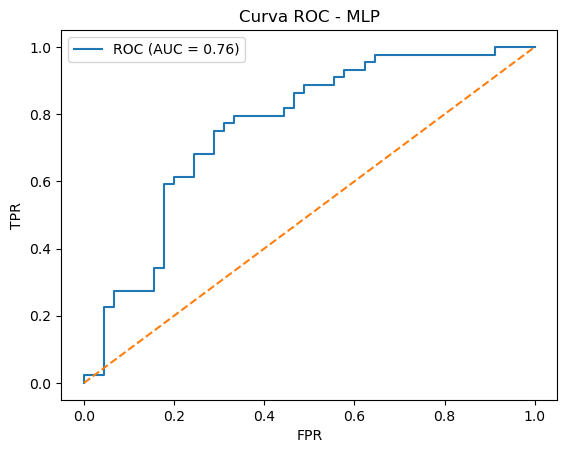

              precision    recall  f1-score   support

           0       0.77      0.67      0.71        45
           1       0.70      0.80      0.74        44

    accuracy                           0.73        89
   macro avg       0.73      0.73      0.73        89
weighted avg       0.74      0.73      0.73        89



dataset              modelo  accuracy  f1_score  precision    recall
7   SMOTE                 MLP  0.730337  0.744681   0.700000  0.795455
0   SMOTE  LogisticRegression  0.685393  0.688889   0.673913  0.704545
5   SMOTE                 SVC  0.674157  0.688172   0.653061  0.727273
4   SMOTE                 KNN  0.617978  0.666667   0.586207  0.772727
6   SMOTE          NaiveBayes  0.651685  0.666667   0.632653  0.704545
1   SMOTE        RandomForest  0.674157  0.650602   0.692308  0.613636
3   SMOTE    GradientBoosting  0.629213  0.645161   0.612245  0.681818
2   SMOTE             XGBoost  0.606742  0.606742   0.600000  0.613636


 Mejor modelo para SMOTE: MLP (F1=0.74)
 Datos con CTGAN
Distribución de clase sintética:
target_bin
0    157
1    143
Name: count, dtype: int64

 Entrenando LogisticRegression con CTGAN


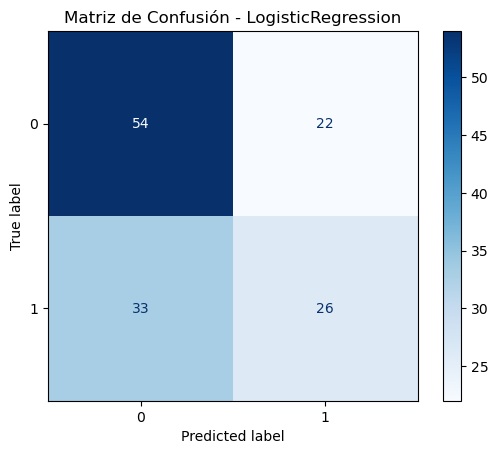

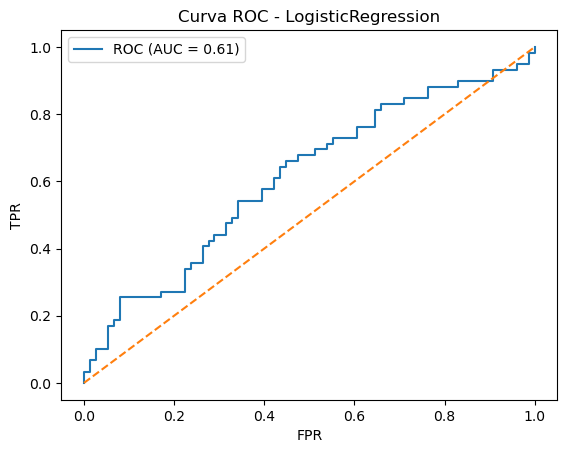

              precision    recall  f1-score   support

           0       0.62      0.71      0.66        76
           1       0.54      0.44      0.49        59

    accuracy                           0.59       135
   macro avg       0.58      0.58      0.57       135
weighted avg       0.59      0.59      0.59       135


 Entrenando RandomForest con CTGAN


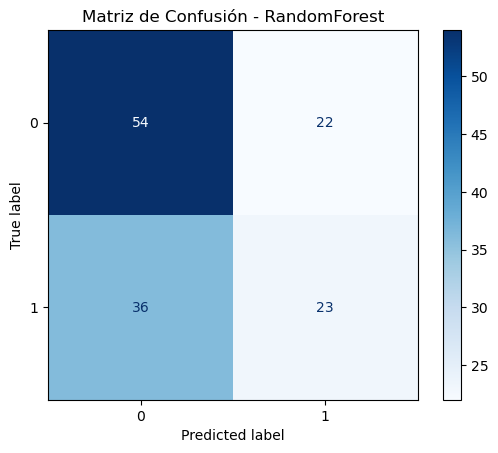

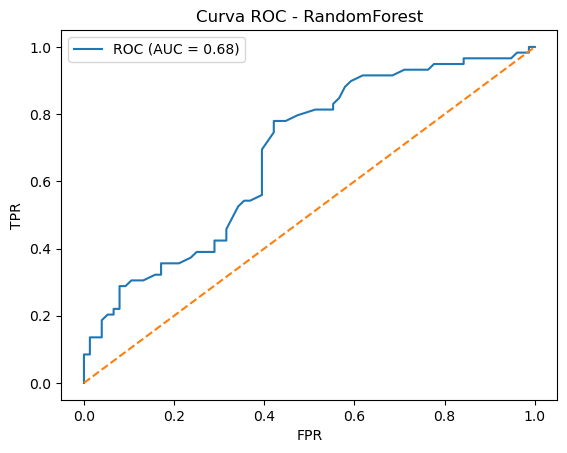

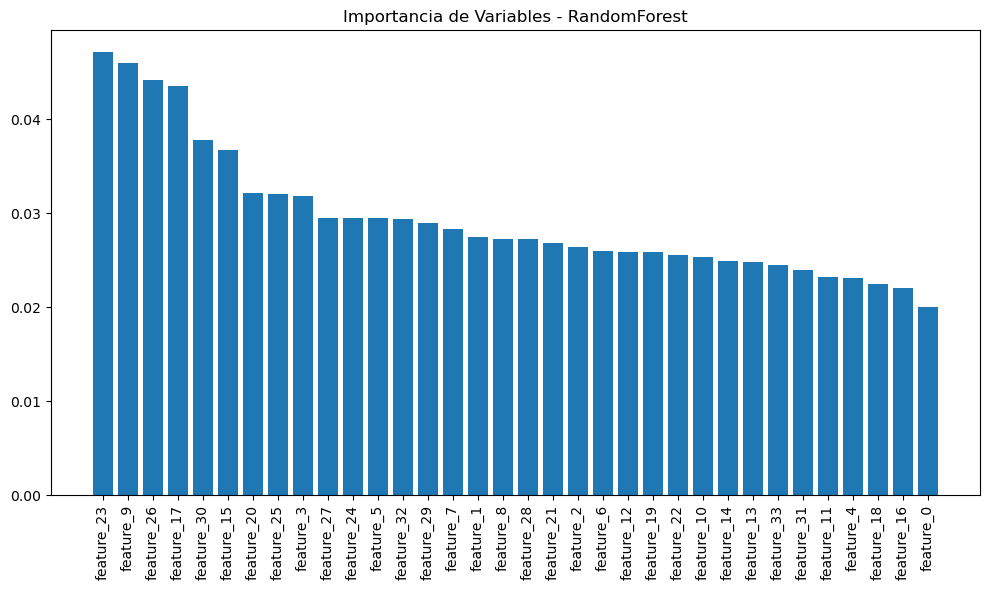

              precision    recall  f1-score   support

           0       0.60      0.71      0.65        76
           1       0.51      0.39      0.44        59

    accuracy                           0.57       135
   macro avg       0.56      0.55      0.55       135
weighted avg       0.56      0.57      0.56       135


 Entrenando XGBoost con CTGAN


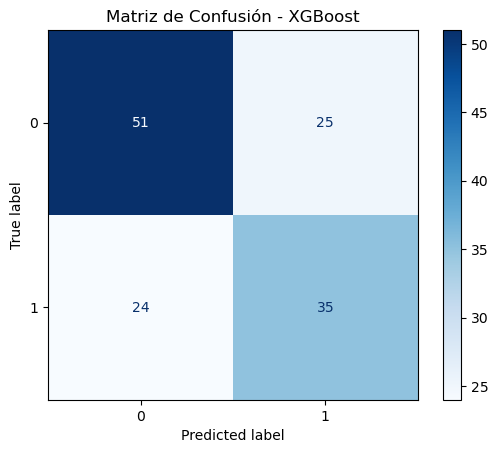

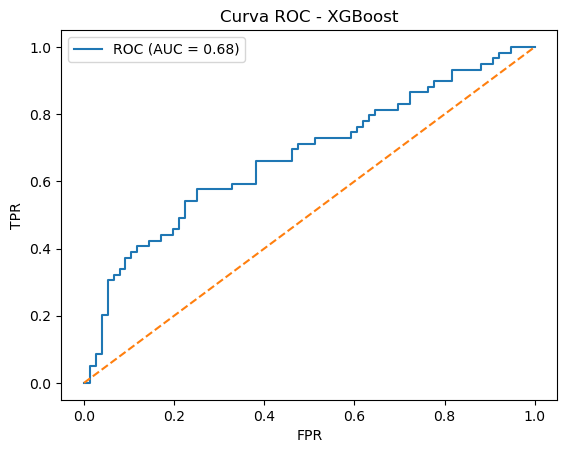

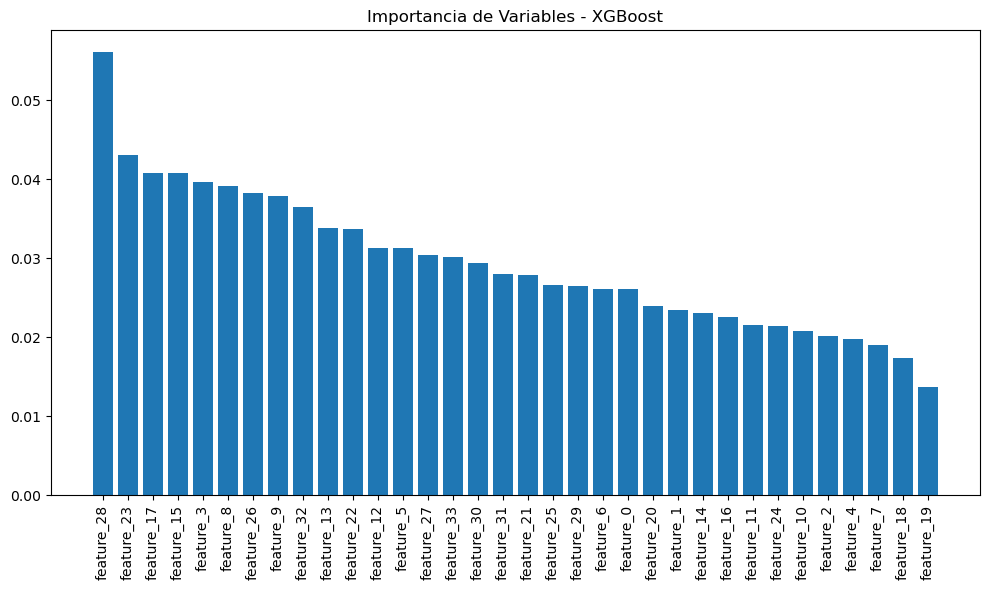

              precision    recall  f1-score   support

           0       0.68      0.67      0.68        76
           1       0.58      0.59      0.59        59

    accuracy                           0.64       135
   macro avg       0.63      0.63      0.63       135
weighted avg       0.64      0.64      0.64       135


 Entrenando GradientBoosting con CTGAN


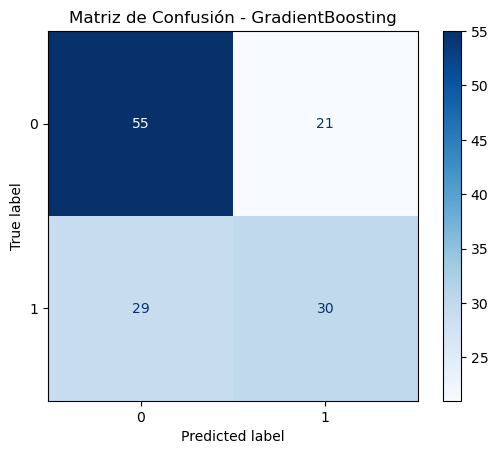

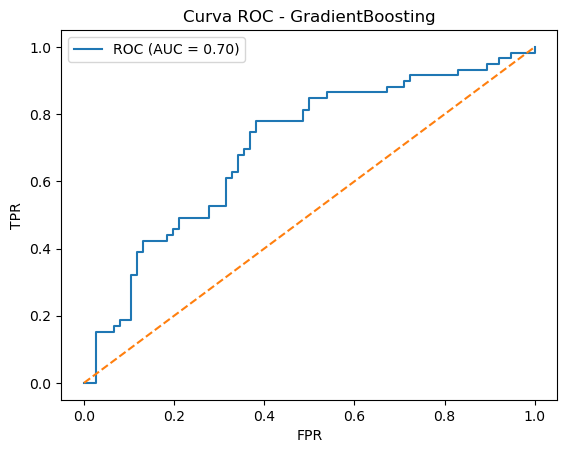

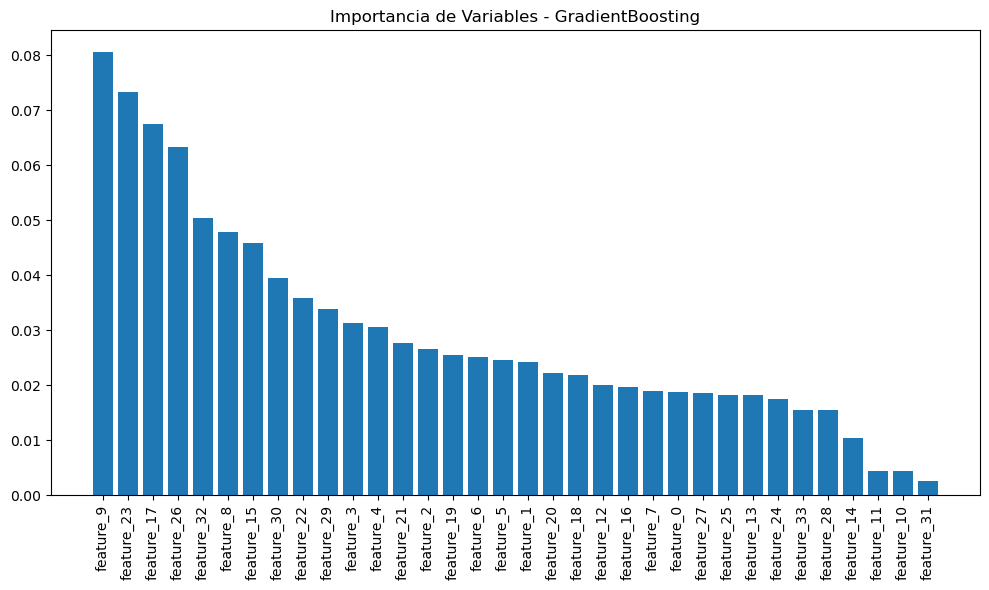

              precision    recall  f1-score   support

           0       0.65      0.72      0.69        76
           1       0.59      0.51      0.55        59

    accuracy                           0.63       135
   macro avg       0.62      0.62      0.62       135
weighted avg       0.63      0.63      0.63       135


 Entrenando KNN con CTGAN


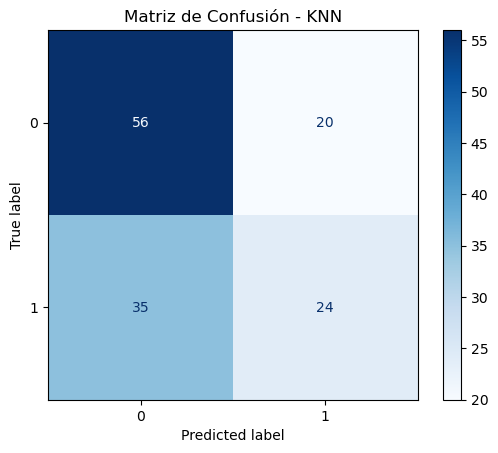

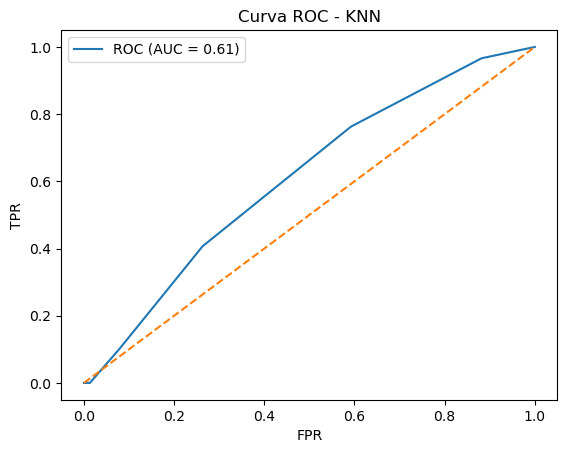

              precision    recall  f1-score   support

           0       0.62      0.74      0.67        76
           1       0.55      0.41      0.47        59

    accuracy                           0.59       135
   macro avg       0.58      0.57      0.57       135
weighted avg       0.58      0.59      0.58       135


 Entrenando SVC con CTGAN


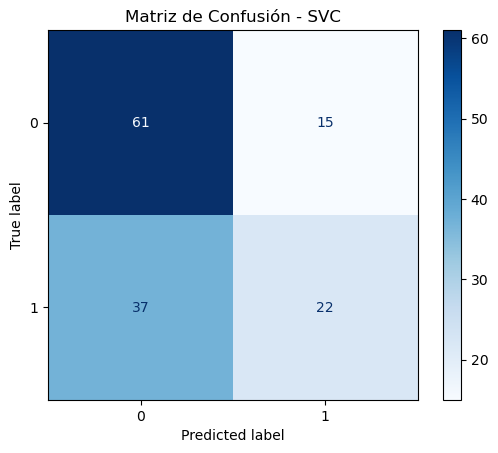

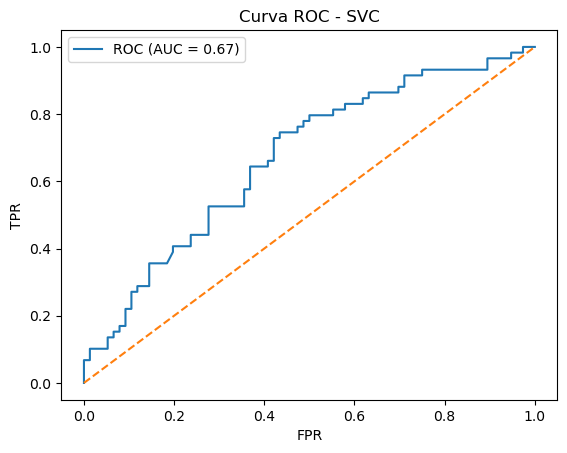

              precision    recall  f1-score   support

           0       0.62      0.80      0.70        76
           1       0.59      0.37      0.46        59

    accuracy                           0.61       135
   macro avg       0.61      0.59      0.58       135
weighted avg       0.61      0.61      0.60       135


 Entrenando NaiveBayes con CTGAN


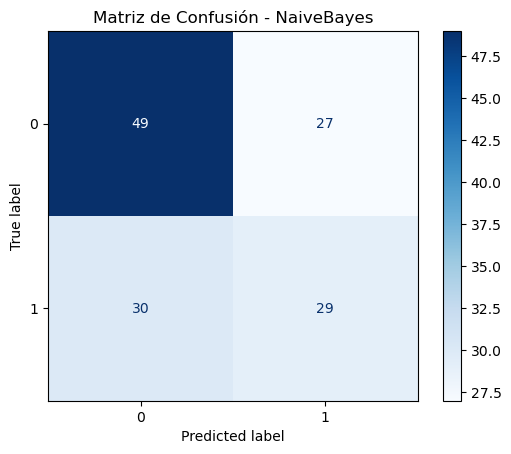

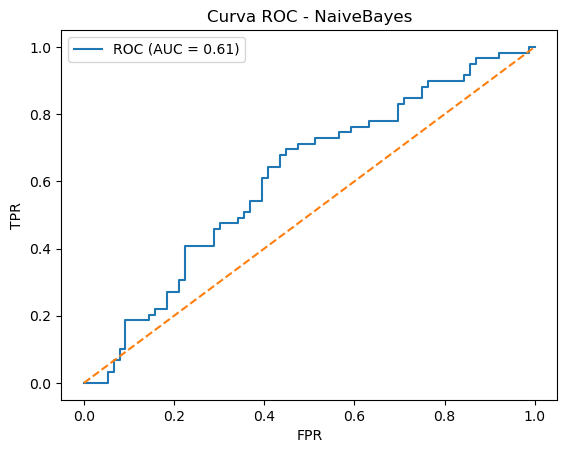

              precision    recall  f1-score   support

           0       0.62      0.64      0.63        76
           1       0.52      0.49      0.50        59

    accuracy                           0.58       135
   macro avg       0.57      0.57      0.57       135
weighted avg       0.58      0.58      0.58       135


 Entrenando MLP con CTGAN


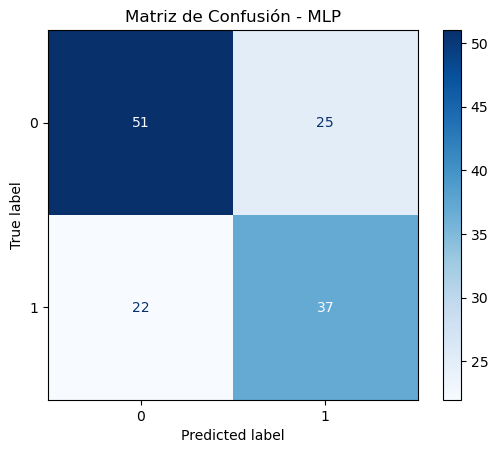

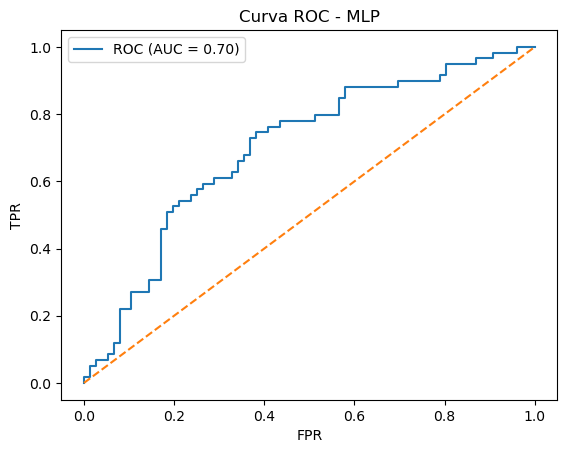

              precision    recall  f1-score   support

           0       0.70      0.67      0.68        76
           1       0.60      0.63      0.61        59

    accuracy                           0.65       135
   macro avg       0.65      0.65      0.65       135
weighted avg       0.65      0.65      0.65       135



dataset              modelo  accuracy  f1_score  precision    recall
7   CTGAN                 MLP  0.651852  0.611570   0.596774  0.627119
2   CTGAN             XGBoost  0.637037  0.588235   0.583333  0.593220
3   CTGAN    GradientBoosting  0.629630  0.545455   0.588235  0.508475
6   CTGAN          NaiveBayes  0.577778  0.504348   0.517857  0.491525
0   CTGAN  LogisticRegression  0.592593  0.485981   0.541667  0.440678
4   CTGAN                 KNN  0.592593  0.466019   0.545455  0.406780
5   CTGAN                 SVC  0.614815  0.458333   0.594595  0.372881
1   CTGAN        RandomForest  0.570370  0.442308   0.511111  0.389831


 Mejor modelo para CTGAN: MLP (F1=0.61)
 Datos con CTGAN + SMOTE

 Entrenando LogisticRegression con CTGAN+SMOTE


`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.


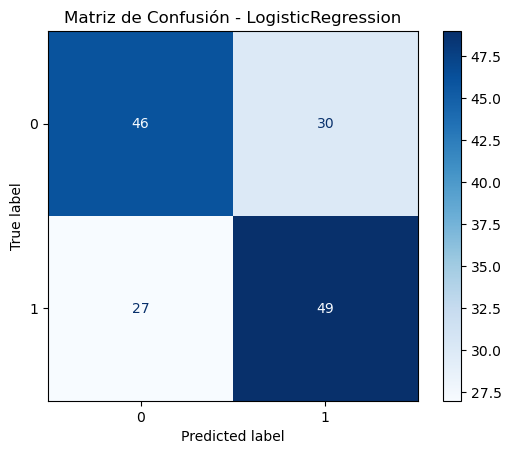

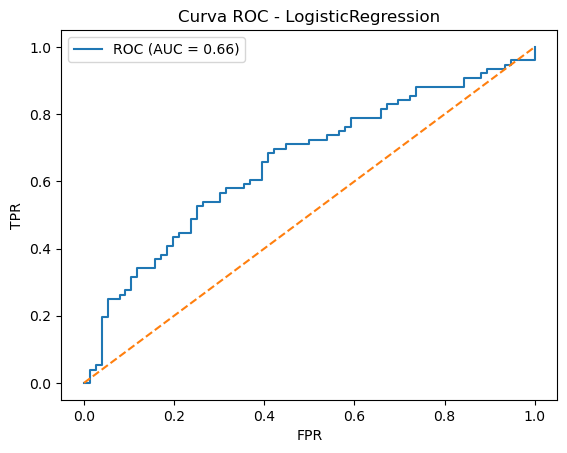

              precision    recall  f1-score   support

           0       0.63      0.61      0.62        76
           1       0.62      0.64      0.63        76

    accuracy                           0.62       152
   macro avg       0.63      0.62      0.62       152
weighted avg       0.63      0.62      0.62       152


 Entrenando RandomForest con CTGAN+SMOTE


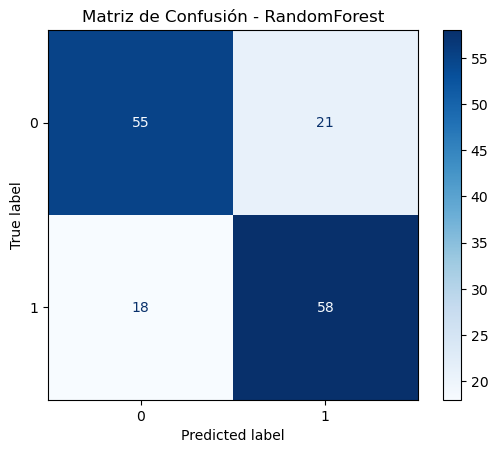

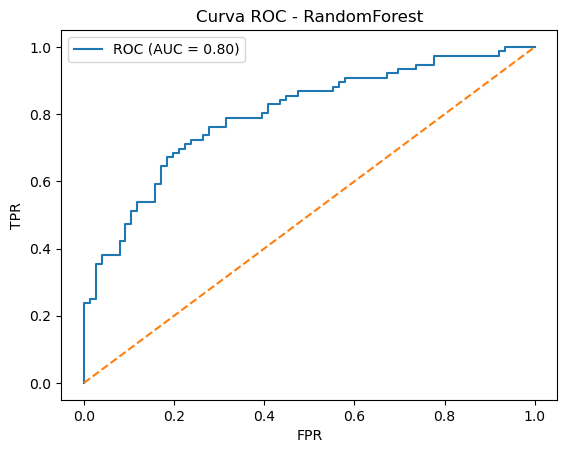

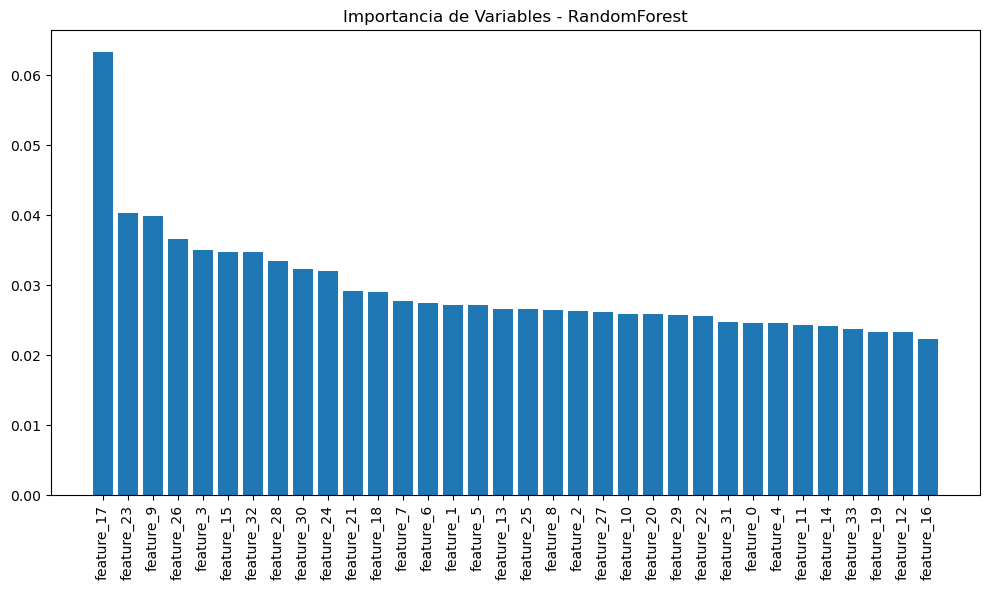

              precision    recall  f1-score   support

           0       0.75      0.72      0.74        76
           1       0.73      0.76      0.75        76

    accuracy                           0.74       152
   macro avg       0.74      0.74      0.74       152
weighted avg       0.74      0.74      0.74       152


 Entrenando XGBoost con CTGAN+SMOTE


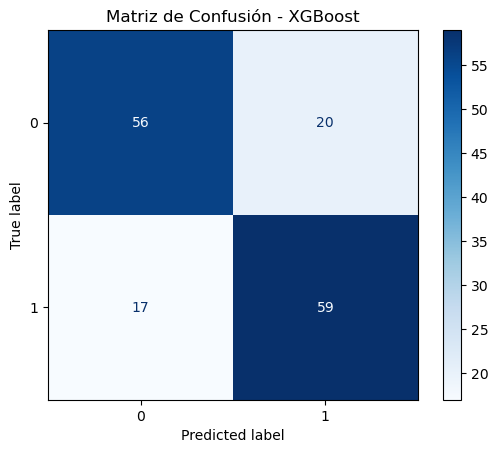

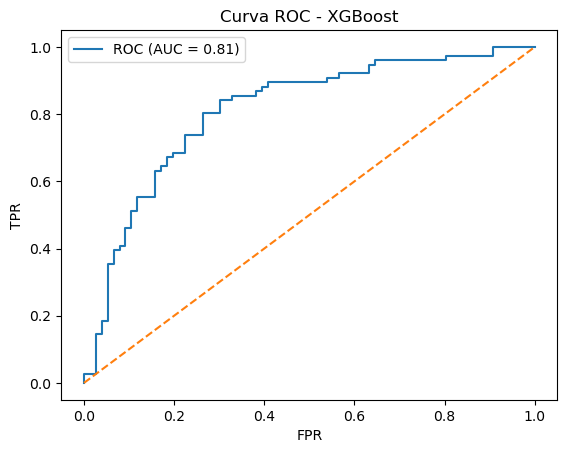

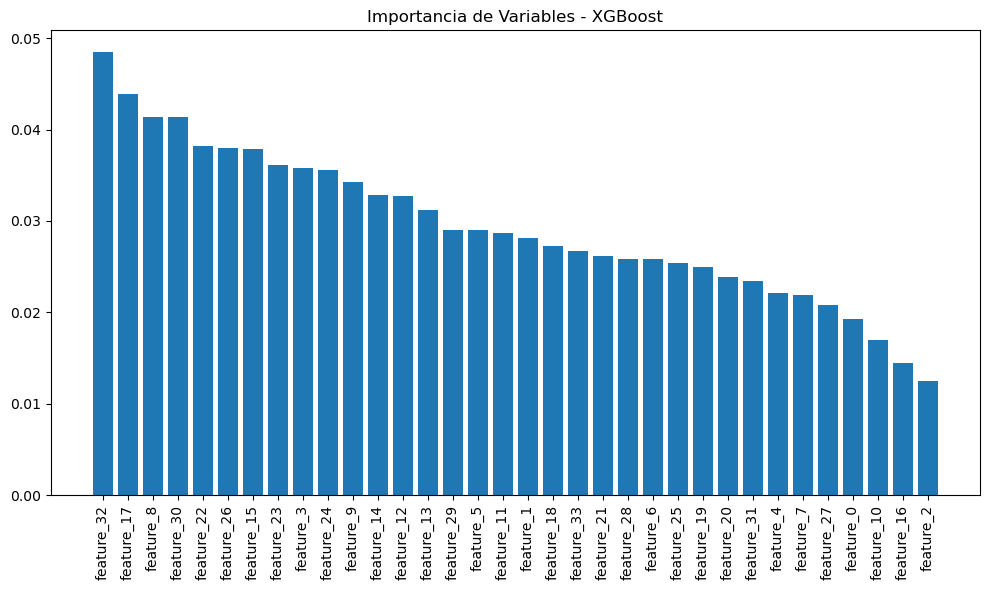

              precision    recall  f1-score   support

           0       0.77      0.74      0.75        76
           1       0.75      0.78      0.76        76

    accuracy                           0.76       152
   macro avg       0.76      0.76      0.76       152
weighted avg       0.76      0.76      0.76       152


 Entrenando GradientBoosting con CTGAN+SMOTE


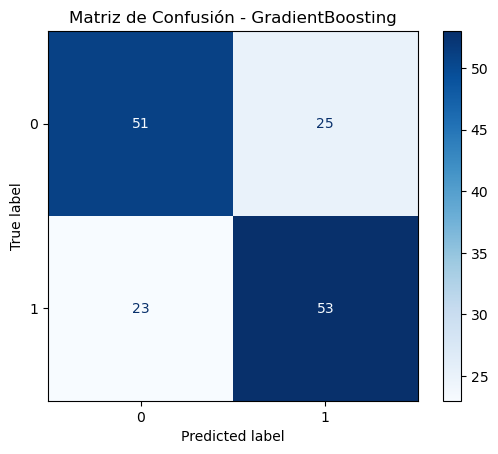

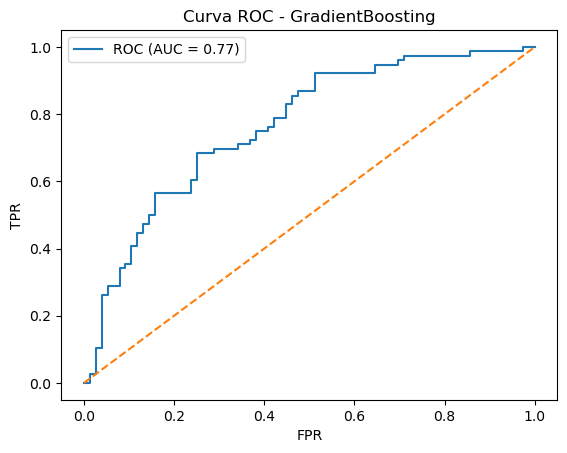

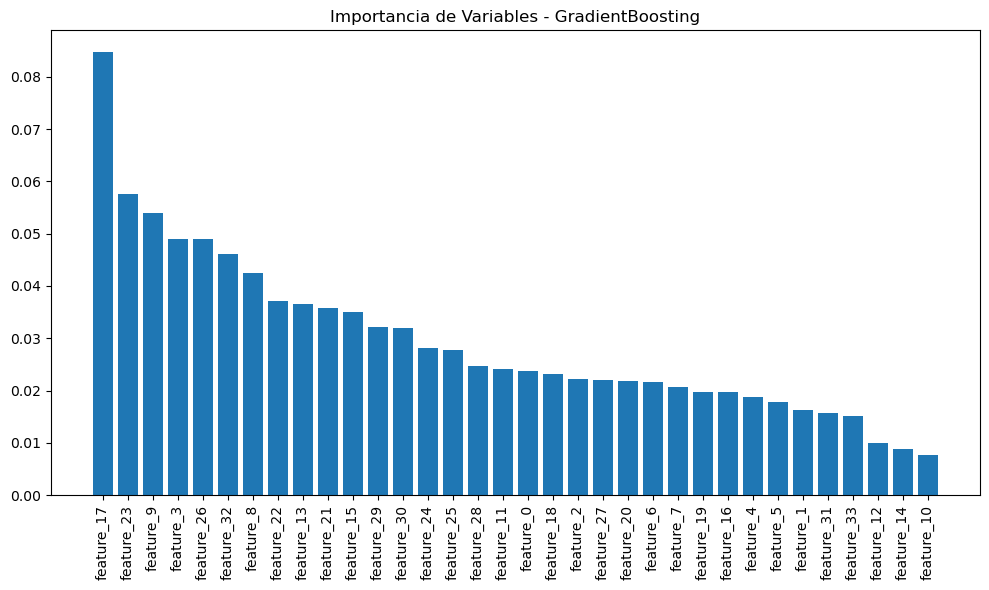

              precision    recall  f1-score   support

           0       0.69      0.67      0.68        76
           1       0.68      0.70      0.69        76

    accuracy                           0.68       152
   macro avg       0.68      0.68      0.68       152
weighted avg       0.68      0.68      0.68       152


 Entrenando KNN con CTGAN+SMOTE


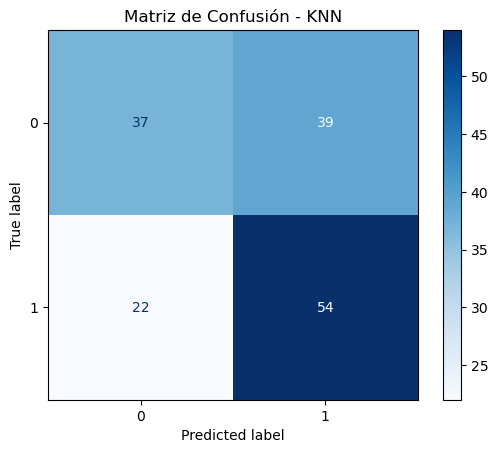

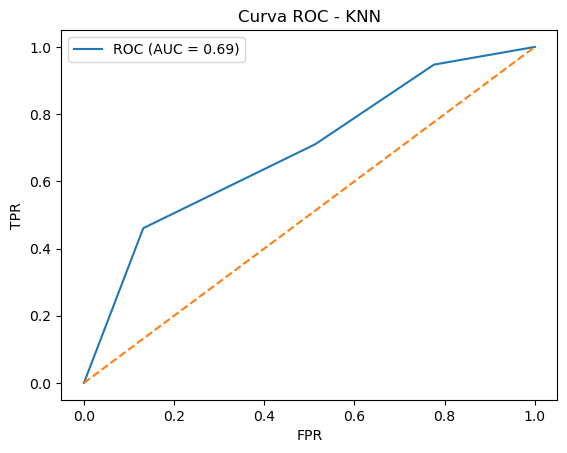

              precision    recall  f1-score   support

           0       0.63      0.49      0.55        76
           1       0.58      0.71      0.64        76

    accuracy                           0.60       152
   macro avg       0.60      0.60      0.59       152
weighted avg       0.60      0.60      0.59       152


 Entrenando SVC con CTGAN+SMOTE


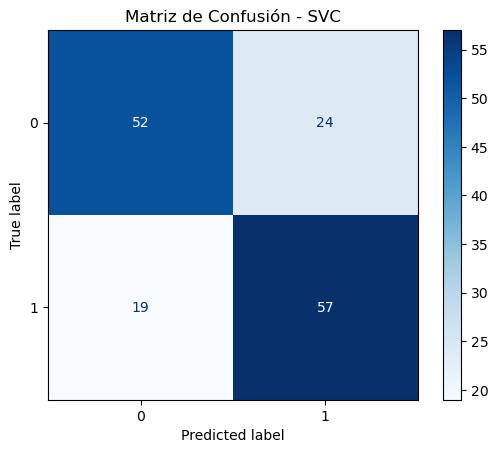

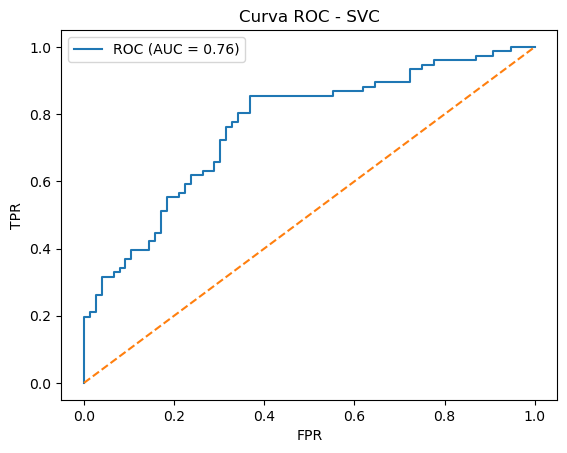

              precision    recall  f1-score   support

           0       0.73      0.68      0.71        76
           1       0.70      0.75      0.73        76

    accuracy                           0.72       152
   macro avg       0.72      0.72      0.72       152
weighted avg       0.72      0.72      0.72       152


 Entrenando NaiveBayes con CTGAN+SMOTE


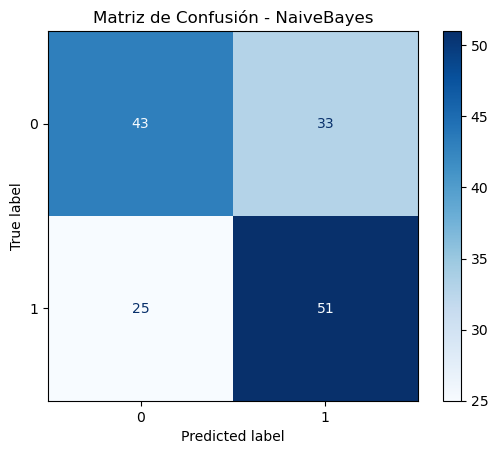

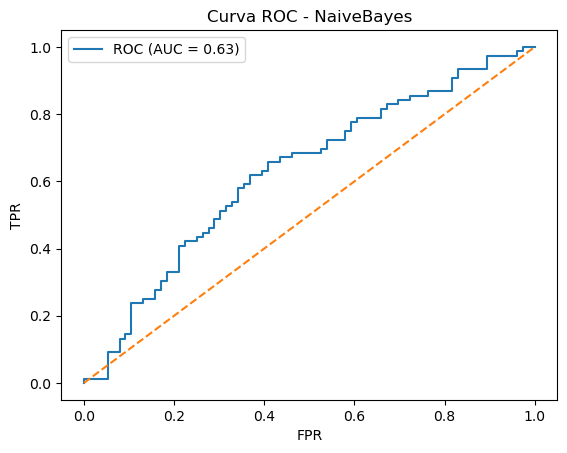

              precision    recall  f1-score   support

           0       0.63      0.57      0.60        76
           1       0.61      0.67      0.64        76

    accuracy                           0.62       152
   macro avg       0.62      0.62      0.62       152
weighted avg       0.62      0.62      0.62       152


 Entrenando MLP con CTGAN+SMOTE


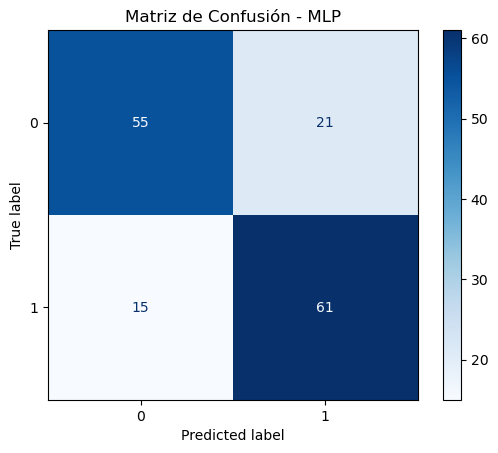

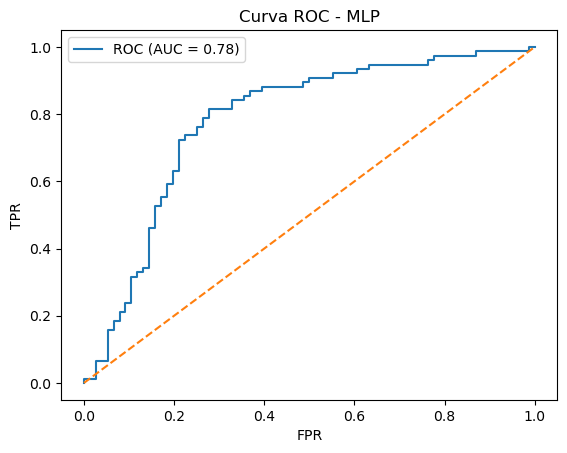

              precision    recall  f1-score   support

           0       0.79      0.72      0.75        76
           1       0.74      0.80      0.77        76

    accuracy                           0.76       152
   macro avg       0.76      0.76      0.76       152
weighted avg       0.76      0.76      0.76       152



dataset              modelo  accuracy  f1_score  precision    recall
7  CTGAN+SMOTE                 MLP  0.763158  0.772152   0.743902  0.802632
2  CTGAN+SMOTE             XGBoost  0.756579  0.761290   0.746835  0.776316
1  CTGAN+SMOTE        RandomForest  0.743421  0.748387   0.734177  0.763158
5  CTGAN+SMOTE                 SVC  0.717105  0.726115   0.703704  0.750000
3  CTGAN+SMOTE    GradientBoosting  0.684211  0.688312   0.679487  0.697368
4  CTGAN+SMOTE                 KNN  0.598684  0.639053   0.580645  0.710526
6  CTGAN+SMOTE          NaiveBayes  0.618421  0.637500   0.607143  0.671053
0  CTGAN+SMOTE  LogisticRegression  0.625000  0.632258   0.620253  0.644737


 Mejor modelo para CTGAN+SMOTE: MLP (F1=0.77)
 Datos con SMOTE + CTGAN
Distribución de clase sintética:
target_bin
0    154
1    146
Name: count, dtype: int64

 Entrenando LogisticRegression con SMOTE+CTGAN


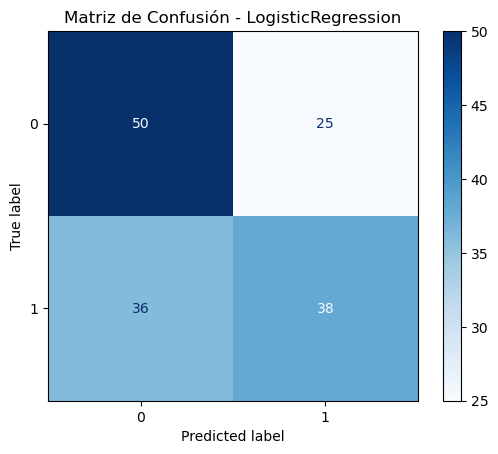

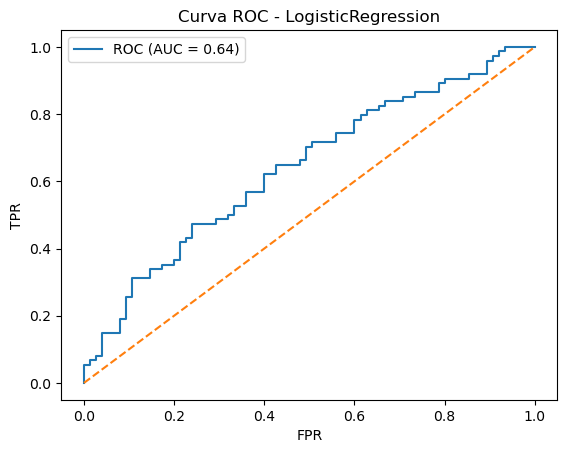

              precision    recall  f1-score   support

           0       0.58      0.67      0.62        75
           1       0.60      0.51      0.55        74

    accuracy                           0.59       149
   macro avg       0.59      0.59      0.59       149
weighted avg       0.59      0.59      0.59       149


 Entrenando RandomForest con SMOTE+CTGAN


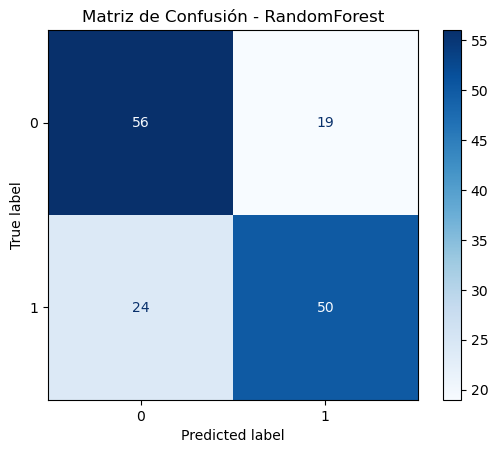

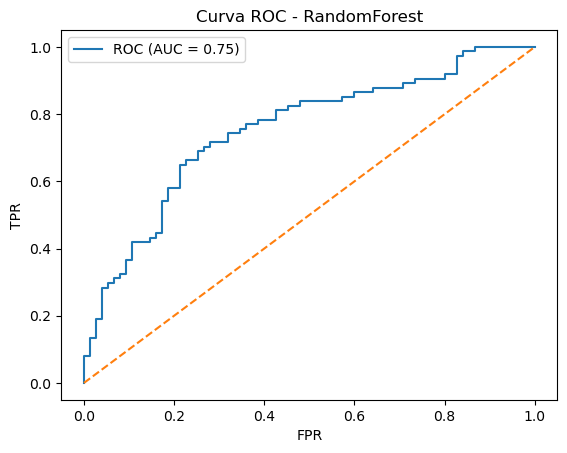

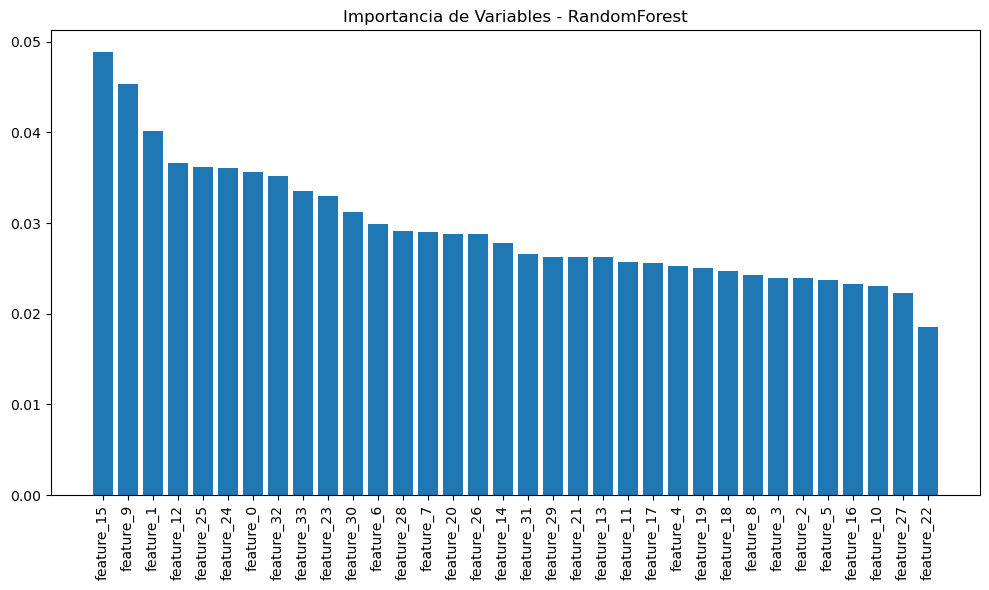

              precision    recall  f1-score   support

           0       0.70      0.75      0.72        75
           1       0.72      0.68      0.70        74

    accuracy                           0.71       149
   macro avg       0.71      0.71      0.71       149
weighted avg       0.71      0.71      0.71       149


 Entrenando XGBoost con SMOTE+CTGAN


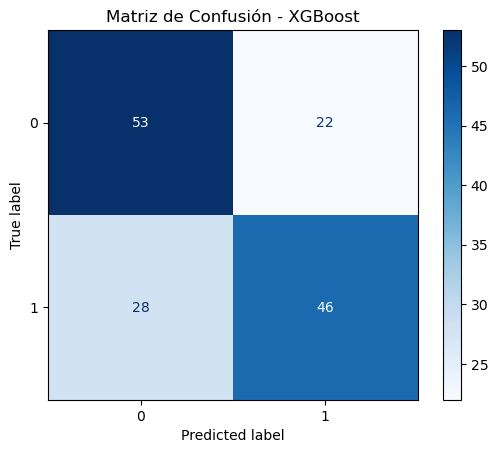

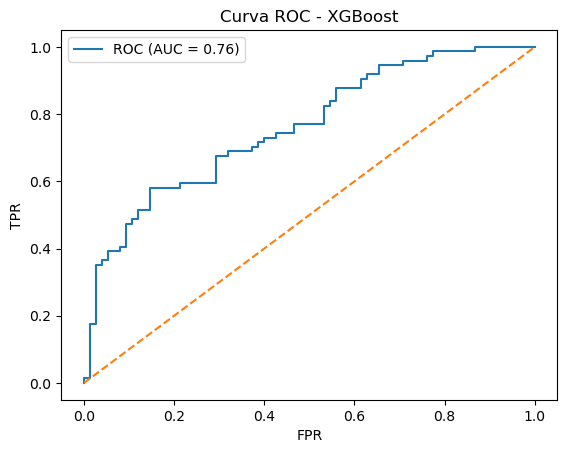

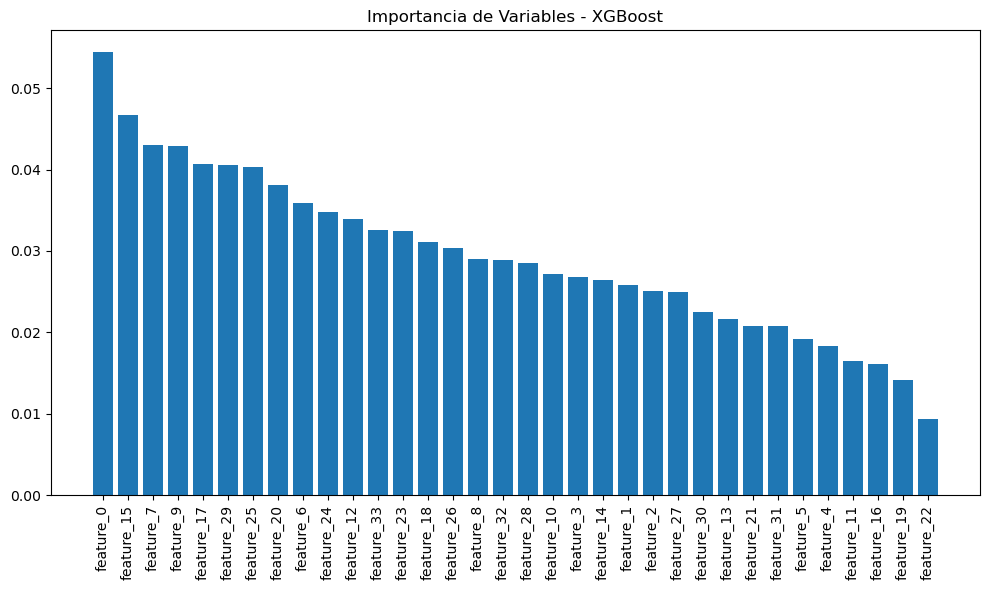

              precision    recall  f1-score   support

           0       0.65      0.71      0.68        75
           1       0.68      0.62      0.65        74

    accuracy                           0.66       149
   macro avg       0.67      0.66      0.66       149
weighted avg       0.67      0.66      0.66       149


 Entrenando GradientBoosting con SMOTE+CTGAN


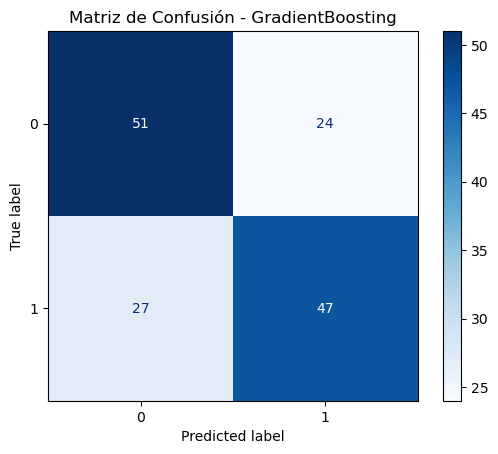

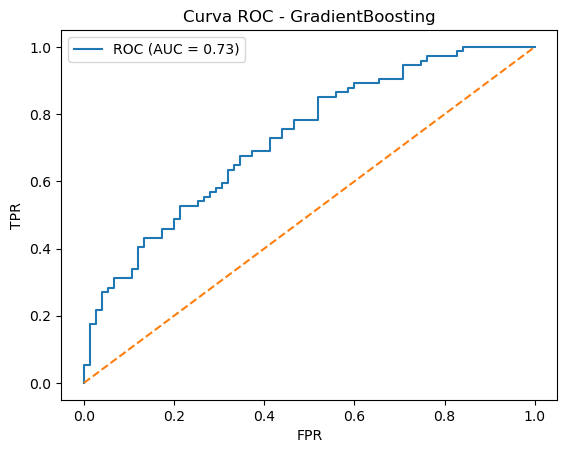

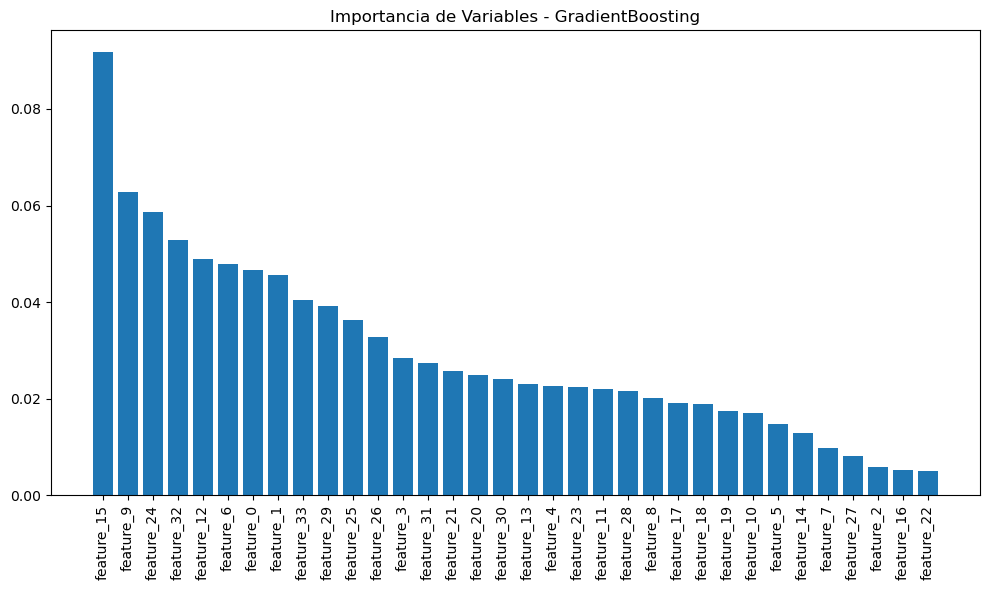

              precision    recall  f1-score   support

           0       0.65      0.68      0.67        75
           1       0.66      0.64      0.65        74

    accuracy                           0.66       149
   macro avg       0.66      0.66      0.66       149
weighted avg       0.66      0.66      0.66       149


 Entrenando KNN con SMOTE+CTGAN


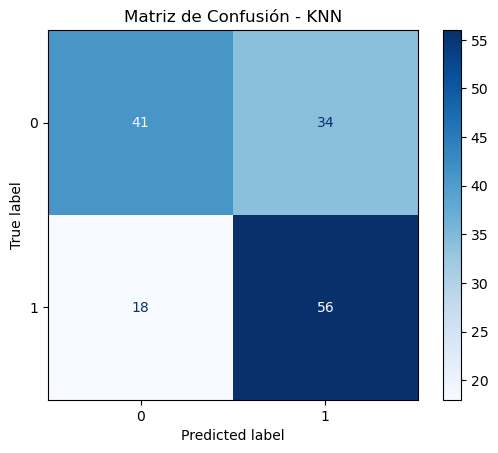

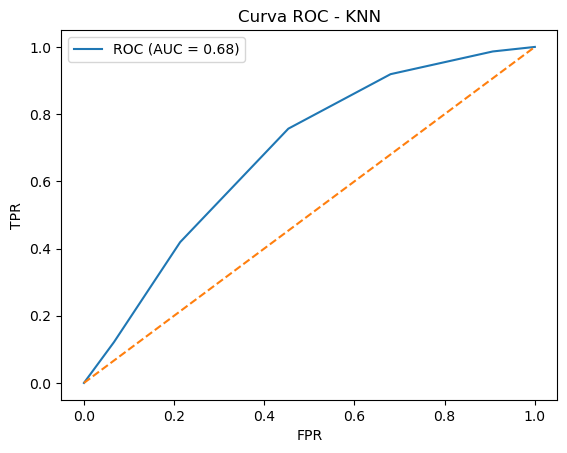

              precision    recall  f1-score   support

           0       0.69      0.55      0.61        75
           1       0.62      0.76      0.68        74

    accuracy                           0.65       149
   macro avg       0.66      0.65      0.65       149
weighted avg       0.66      0.65      0.65       149


 Entrenando SVC con SMOTE+CTGAN


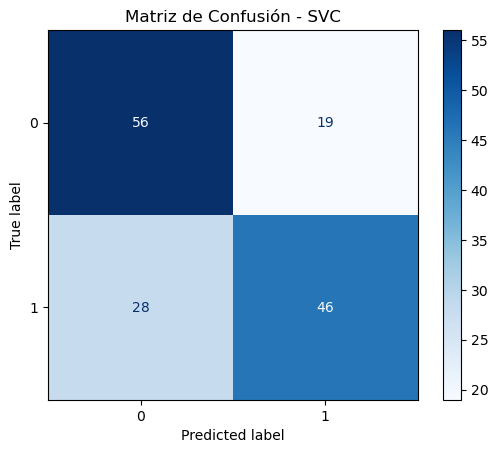

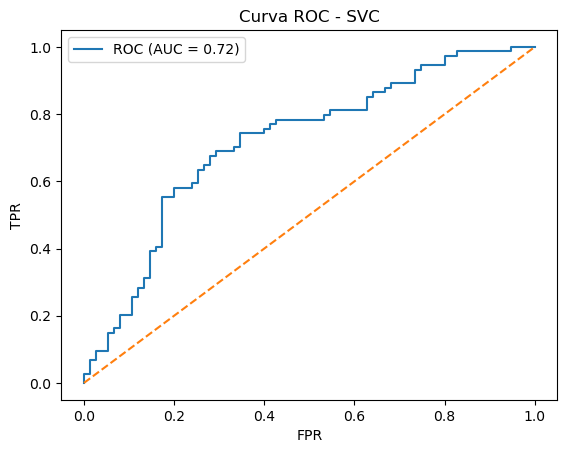

              precision    recall  f1-score   support

           0       0.67      0.75      0.70        75
           1       0.71      0.62      0.66        74

    accuracy                           0.68       149
   macro avg       0.69      0.68      0.68       149
weighted avg       0.69      0.68      0.68       149


 Entrenando NaiveBayes con SMOTE+CTGAN


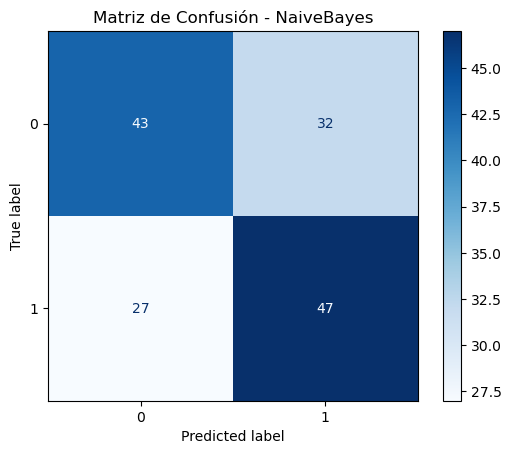

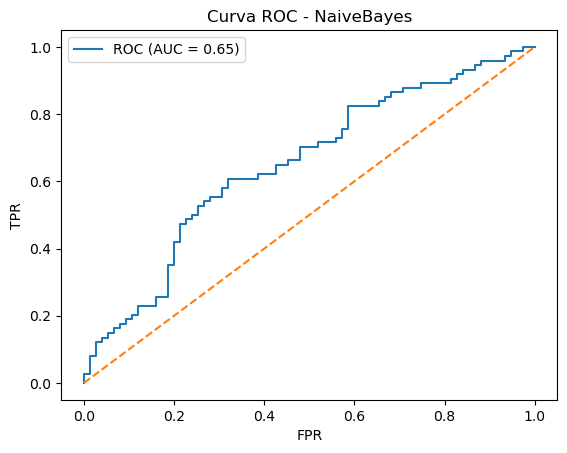

              precision    recall  f1-score   support

           0       0.61      0.57      0.59        75
           1       0.59      0.64      0.61        74

    accuracy                           0.60       149
   macro avg       0.60      0.60      0.60       149
weighted avg       0.60      0.60      0.60       149


 Entrenando MLP con SMOTE+CTGAN


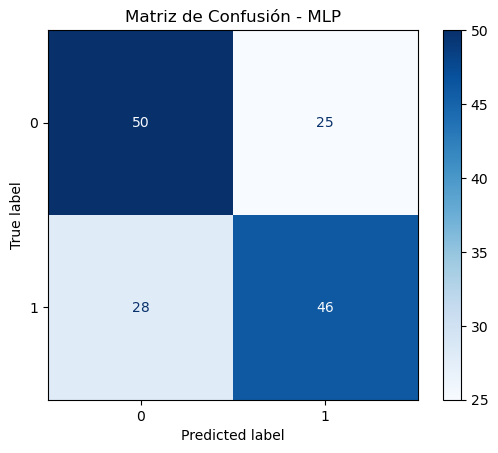

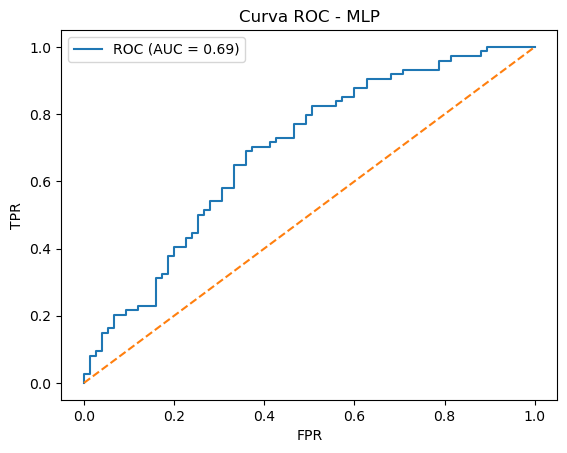

              precision    recall  f1-score   support

           0       0.64      0.67      0.65        75
           1       0.65      0.62      0.63        74

    accuracy                           0.64       149
   macro avg       0.64      0.64      0.64       149
weighted avg       0.64      0.64      0.64       149



dataset              modelo  accuracy  f1_score  precision    recall
1  SMOTE+CTGAN        RandomForest  0.711409  0.699301   0.724638  0.675676
4  SMOTE+CTGAN                 KNN  0.651007  0.682927   0.622222  0.756757
5  SMOTE+CTGAN                 SVC  0.684564  0.661871   0.707692  0.621622
3  SMOTE+CTGAN    GradientBoosting  0.657718  0.648276   0.661972  0.635135
2  SMOTE+CTGAN             XGBoost  0.664430  0.647887   0.676471  0.621622
7  SMOTE+CTGAN                 MLP  0.644295  0.634483   0.647887  0.621622
6  SMOTE+CTGAN          NaiveBayes  0.604027  0.614379   0.594937  0.635135
0  SMOTE+CTGAN  LogisticRegression  0.590604  0.554745   0.603175  0.513514


 Mejor modelo para SMOTE+CTGAN: RandomForest (F1=0.70)

 Generando tabla comparativa final...


dataset             CTGAN  CTGAN+SMOTE  Original  SMOTE  SMOTE+CTGAN
modelo                                                              
GradientBoosting     0.55         0.69      0.46   0.65         0.65
KNN                  0.47         0.64      0.41   0.67         0.68
LogisticRegression   0.49         0.63      0.47   0.69         0.55
MLP                  0.61         0.77      0.41   0.74         0.63
NaiveBayes           0.50         0.64      0.60   0.67         0.61
RandomForest         0.44         0.75      0.42   0.65         0.70
SVC                  0.46         0.73      0.42   0.69         0.66
XGBoost              0.59         0.76      0.33   0.61         0.65


 Mejor modelo por dataset:
- CTGAN: MLP (F1 = 0.61)
- CTGAN+SMOTE: MLP (F1 = 0.77)
- Original: NaiveBayes (F1 = 0.60)
- SMOTE: MLP (F1 = 0.74)
- SMOTE+CTGAN: RandomForest (F1 = 0.70)

 Mejor modelo global: MLP con CTGAN+SMOTE (F1 = 0.77)


In [5]:
if __name__ == "__main__":
    df = pd.read_parquet("companies_T_anon.parquet")
    todos_los_resultados = []
    df = preprocesar_datos(df)
    df = seleccionar_variables(df, target_col="target_bin")
    X = df.drop(columns=["target_bin"])
    y = df["target_bin"]

    print(" Datos originales")
    resultados = entrenar_modelos(X, y, dataset_name="Original")
    todos_los_resultados.extend(resultados)

    print(" Datos con SMOTE")
    X_smote, y_smote = SMOTE(random_state=42).fit_resample(X, y)
    resultados = entrenar_modelos(X_smote, y_smote, dataset_name="SMOTE")
    todos_los_resultados.extend(resultados)
    
    print(" Datos con CTGAN")
    X_ctgan, y_ctgan = generar_datos_ctgan(X, y)
    resultados = entrenar_modelos(X_ctgan, y_ctgan, dataset_name="CTGAN")
    todos_los_resultados.extend(resultados)
    
    print(" Datos con CTGAN + SMOTE")
    X_ctgan_smote, y_ctgan_smote = SMOTE(random_state=42).fit_resample(X_ctgan, y_ctgan)
    resultados = entrenar_modelos(X_ctgan_smote, y_ctgan_smote, dataset_name="CTGAN+SMOTE")
    todos_los_resultados.extend(resultados)
    
    print(" Datos con SMOTE + CTGAN")
    X_smote_ctgan, y_smote_ctgan = generar_datos_ctgan(X_smote, y_smote)
    resultados = entrenar_modelos(X_smote_ctgan, y_smote_ctgan, dataset_name="SMOTE+CTGAN")
    todos_los_resultados.extend(resultados) 
    
    print("\n Generando tabla comparativa final...")
    generar_tabla_comparativa_f1(todos_los_resultados)

La función entrenar_modelos es el motor del experimento. Utiliza GridSearchCV para ajustar los hiperparámetros de ocho clasificadores diferentes (incluyendo RandomForest, MLP, XGBoost, entre otros) y evalúa su rendimiento utilizando métricas estándar como accuracy, precision, recall y f1-score. Para cada experimento, se visualizan matrices de confusión, curvas ROC y gráficas de importancia de variables. Al final del proceso, se genera una tabla comparativa final que resume los F1-scores por dataset y destaca el mejor modelo de cada conjunto, así como el modelo global más sólido.

Los resultados muestran claramente que los modelos entrenados con datos enriquecidos superan a los que usan solo datos originales. En particular, la combinación CTGAN + SMOTE permite obtener el mejor desempeño general, alcanzando un F1-score de 0.77 con un modelo MLP, lo que lo posiciona como el mejor modelo global del experimento. Le siguen muy de cerca XGBoost y RandomForest, también sobre datos CTGAN+SMOTE. En cambio, sobre el dataset original, los resultados fueron notablemente más bajos (F1 máximo de 0.60 con Naive Bayes), confirmando la dificultad de trabajar con small data desbalanceados.

Además, este experimento pone en evidencia que la estructura del modelo y el enriquecimiento de los datos deben ir de la mano. Mientras Naive Bayes y SVC son razonables sobre datos sin sintetizar, modelos como MLP o XGBoost requieren datasets más ricos y equilibrados para destacar. También se observa que, aunque se fija una semilla común (random_state=42), hay ligeras diferencias entre ejecuciones en distintos entornos (por ejemplo, Jupyter vs Visual Studio Code), lo que refuerza la necesidad de explicabilidad adicional mediante SHAP.



### SHAP (Random Forest)

En esta sección se procede a la interpretación del modelo seleccionado como el mejor clasificador global: Random Forest entrenado sobre los datos generados con CTGAN y balanceados con SMOTE. El objetivo es comprender qué variables están influyendo más en la predicción de la clase positiva (empresas con calificación alta).

El flujo seguido parte del dataset preprocesado, sobre el cual se genera un conjunto sintético con CTGAN, enriquecido con la técnica de sobremuestreo SMOTE. A continuación, se entrena un modelo de Random Forest utilizando una partición de entrenamiento estratificada, y se reserva un subconjunto para análisis con SHAP (SHapley Additive exPlanations).

Se utiliza el TreeExplainer de SHAP, diseñado específicamente para modelos de árbol, lo que permite obtener valores SHAP de forma eficiente. El gráfico de tipo summary plot generado resume el impacto de cada variable en la predicción de la clase 1. Las variables aparecen ordenadas de mayor a menor importancia en términos del promedio absoluto de sus valores SHAP. Además, el color indica el valor original de cada variable (rojo para valores altos, azul para bajos), y la dispersión muestra cómo afecta a la predicción positiva.

Esta visualización permite identificar las variables más influyentes y entender su efecto. Por ejemplo, si una variable aparece en la parte superior y los puntos rojos están a la derecha, indica que valores altos de dicha variable aumentan la probabilidad de pertenecer a la clase 1. Este análisis es fundamental para validar que el modelo toma decisiones coherentes y para generar conocimiento útil sobre los factores que contribuyen al éxito empresarial según la clasificación binaria planteada.

Como los valores con % en las variables representan variaciones relativas (es decir, (valor_final - valor_inicial) / valor_inicial), es importante interpretarlos como indicadores de cambio o crecimiento/disminución relativo y no como cantidades absolutas.

Por ejemplo:

- gastos_personal% indica el cambio relativo en los gastos de personal respecto a su valor inicial. Un valor alto sugiere que estos gastos han aumentado significativamente, lo que puede reflejar inestabilidad, expansión poco controlada o falta de eficiencia, y por eso podría asociarse a mayor riesgo en la predicción del modelo.

- dfn_ebitda% (deuda financiera neta respecto al EBITDA) muestra cómo ha variado la capacidad de la empresa para cubrir su deuda con beneficios operativos. Altas variaciones negativas o positivas pueden ser señales de alerta para el modelo.

Este enfoque de usar porcentajes como deltas permite normalizar las diferencias entre empresas de distintos tamaños, lo cual es especialmente útil en escenarios de small data. Además, mejora la capacidad del modelo para detectar patrones de evolución y no solo estados estáticos. Así, estos porcentajes aportan una capa muy valiosa de interpretación temporal o dinámica del riesgo.

Eliminando por baja varianza: ['cash_flow_antes_var']
Eliminando por alta correlacion: []
Distribución de clase sintética:
target_bin
0    157
1    143
Name: count, dtype: int64


`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.


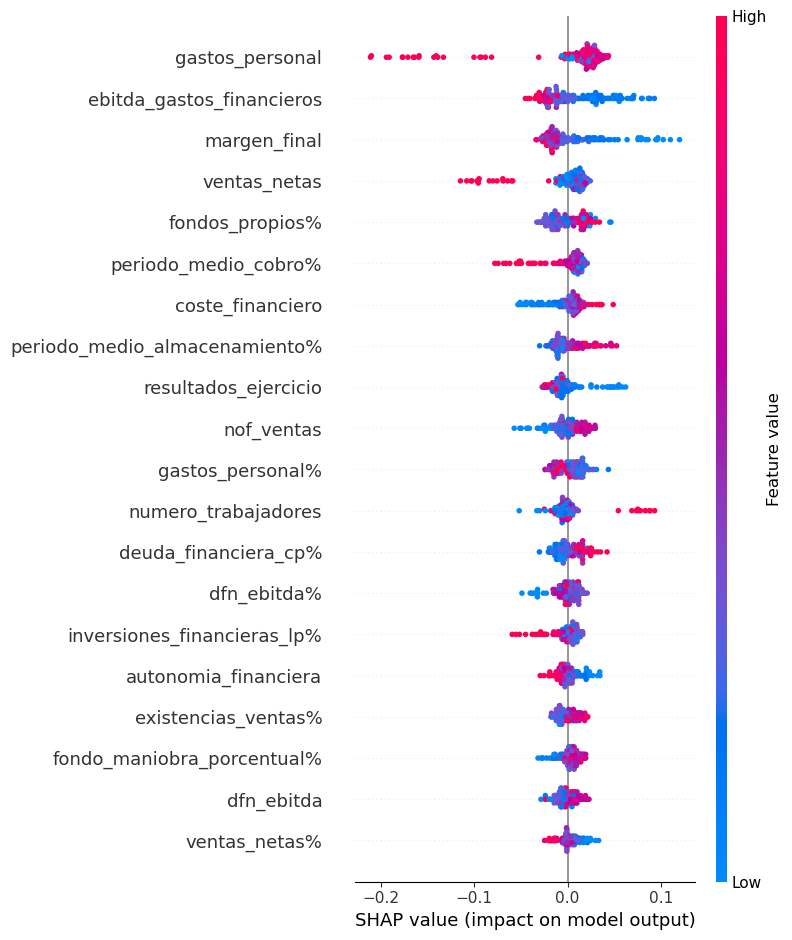

In [7]:
import shap
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Leer datos
df = pd.read_parquet("companies_T_anon.parquet")

# Preprocesamiento
df = preprocesar_datos(df)
df = seleccionar_variables(df, target_col="target_bin")

# Separar X e y
y = df["target_bin"]
X = df.drop(columns=["target_bin"])

# ✅ Generar datos sintéticos con CTGAN
X_ctgan, y_ctgan = generar_datos_ctgan(X, y)

# ✅ Aplicar SMOTE sobre datos sintéticos
X_ctgan_smote, y_ctgan_smote = SMOTE(random_state=42).fit_resample(X_ctgan, y_ctgan)

# Separar en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_ctgan_smote, y_ctgan_smote, test_size=0.2, stratify=y_ctgan_smote, random_state=42
)

# Convertir a DataFrame (para SHAP)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Entrenar modelo
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# SHAP explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_df)

# Mostrar summary plot para clase 1 (positiva)
shap.summary_plot(shap_values[1], X_test_df)

Este gráfico corresponde a un summary plot de SHAP para la clase 1 (riesgo alto) generado a partir de un modelo Random Forest entrenado con un conjunto de datos enriquecido. La visualización permite analizar el impacto de cada variable en la predicción del modelo, mostrando no solo la importancia relativa de cada característica, sino también el efecto de sus valores altos o bajos sobre la probabilidad de clasificar una empresa como de riesgo elevado.

En el eje vertical se presentan las variables ordenadas de mayor a menor impacto medio. Cada punto representa una observación individual del conjunto de test: el eje horizontal indica el valor SHAP (positivo = empuja hacia riesgo alto, negativo = hacia riesgo bajo), mientras que el color muestra si el valor original de la variable era alto (rojo) o bajo (azul).

Entre las variables más influyentes destacan:

- gastos_personal y ebitda_gastos_financieros, donde valores elevados tienden a aumentar la probabilidad de riesgo, lo que puede asociarse a estructuras de costes poco sostenibles.

- margen_final y ventas_netas tienen un impacto más balanceado, aunque en general, valores bajos parecen asociarse con un mayor riesgo (puntos azules desplazados a la derecha).

- Algunas variables como fondo_maniobra_porcentual%, ventas_netas% o autonomía financiera muestran impacto limitado, pero aún así contribuyen ligeramente a la clasificación.

También se aprecian efectos interesantes como en numero_trabajadores, donde valores muy altos (rojo) pueden estar asociados con riesgo elevado en algunos casos, posiblemente por estructuras sobredimensionadas o ineficientes en pequeñas empresas.

Este tipo de análisis permite entender cómo el modelo está utilizando la información financiera para tomar decisiones, facilitando la validación de su lógica interna y reforzando su transparencia, lo cual es esencial en contextos financieros donde se requiere explicar las predicciones ante usuarios o reguladores.

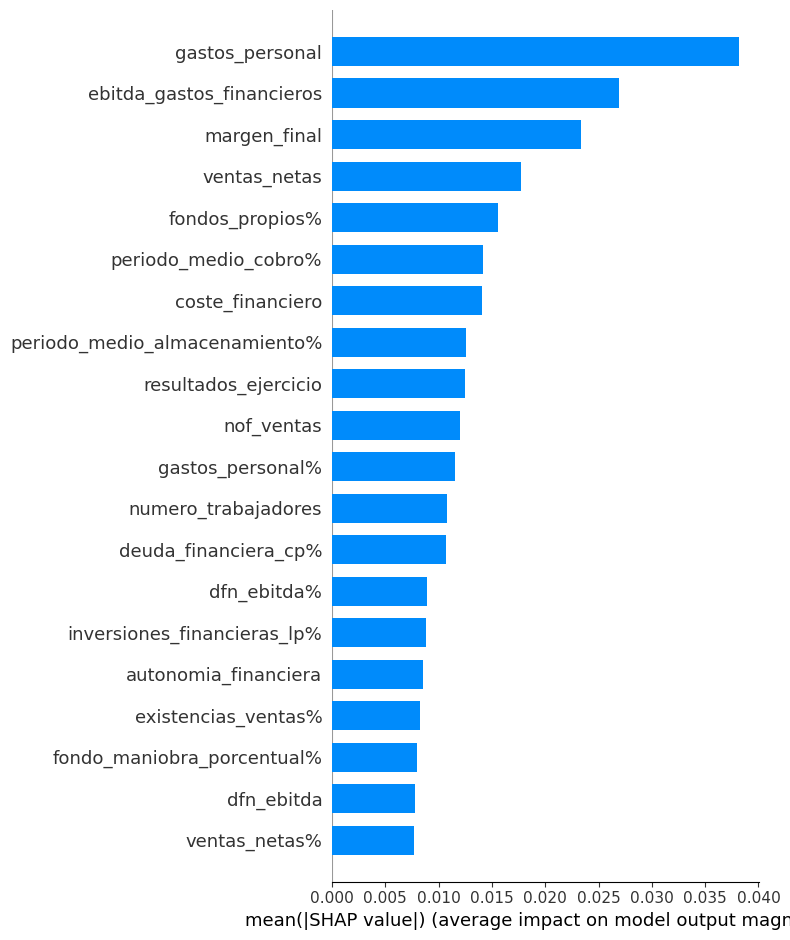

In [9]:
shap.summary_plot(shap_values[1], X_test_df, plot_type="bar")

Este gráfico corresponde al SHAP bar plot, una representación del impacto medio absoluto de cada variable sobre la salida del modelo. A diferencia del summary plot, aquí no se muestra la dirección del efecto (si empuja hacia más o menos riesgo), sino únicamente cuánto contribuye cada variable —en promedio— a la predicción final. Esta información es útil para entender qué variables tienen mayor peso en la toma de decisiones del modelo, independientemente de sus valores concretos.

La variable más influyente es claramente gastos_personal, seguida de ebitda_gastos_financieros y margen_final, lo que indica que el modelo considera críticamente los gastos laborales y la rentabilidad financiera como factores clave en la clasificación de riesgo. Estas tres variables destacan con una contribución media significativamente superior al resto, lo que sugiere que dominan las decisiones del modelo en muchos casos.

Otras variables también relevantes incluyen ventas_netas, fondos_propios%, coste_financiero y los distintos indicadores de gestión como periodo_medio_cobro% y periodo_medio_almacenamiento%, que reflejan tanto la capacidad operativa como la eficiencia financiera de las empresas analizadas.

Hacia el final del gráfico aparecen variables con menor impacto, como existencias_ventas%, autonomía financiera o ventas_netas%, que si bien pueden tener sentido en el análisis financiero, parecen tener un rol más complementario en la lógica de predicción del modelo.

Este análisis permite priorizar las variables más críticas para el modelo, lo cual es esencial tanto para la interpretación de las decisiones individuales como para la validación del modelo desde una perspectiva de negocio o cumplimiento normativo. Además, puede ser útil para futuras simplificaciones del modelo o para construir reglas de decisión explicables basadas en las variables más determinantes.


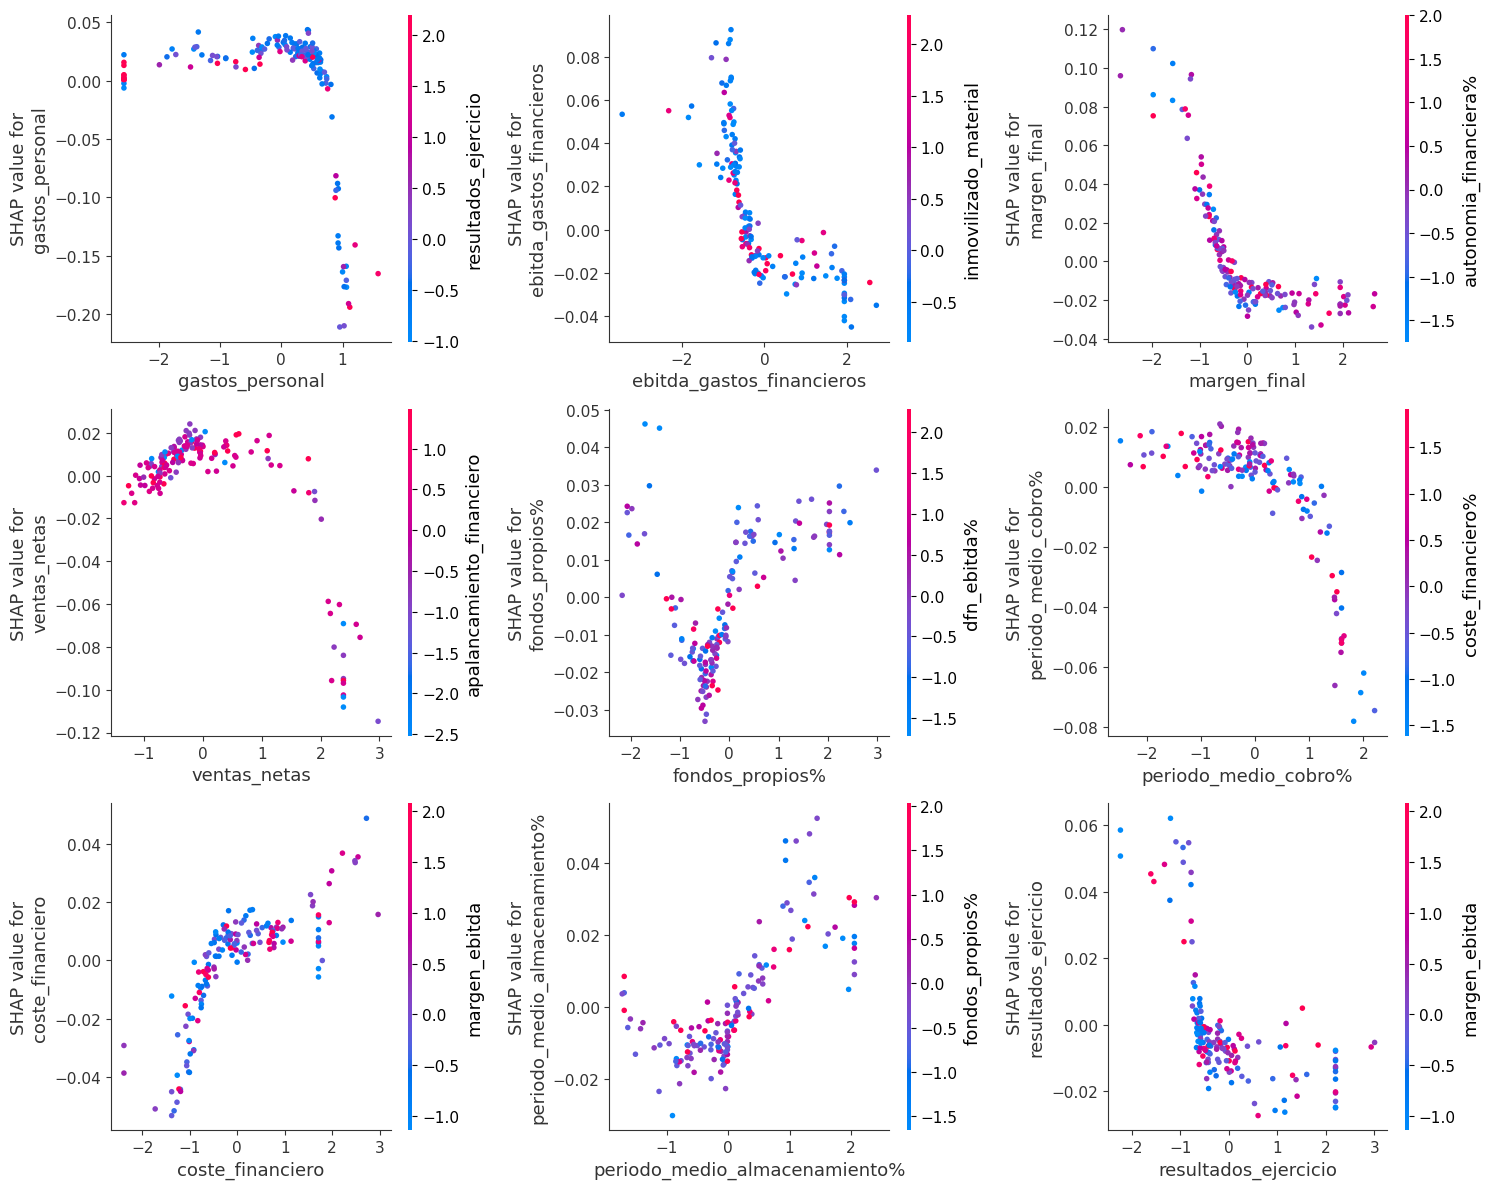

In [12]:
import shap
import matplotlib.pyplot as plt
import math

# Número de variables a mostrar
n_features = 9  # Cambia esto si quieres más o menos
top_features = np.argsort(np.abs(shap_values[1]).mean(0))[-n_features:][::-1]
feature_names = X_test_df.columns[top_features]

# Crear subplots
cols = 3
rows = math.ceil(n_features / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()

for i, feature in enumerate(feature_names):
    shap.dependence_plot(
        feature,
        shap_values[1], 
        X_test_df,
        ax=axes[i],
        show=False
    )
    
# Eliminar subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Este conjunto de dependence plots generados con SHAP permite analizar en detalle cómo afectan los valores específicos de ciertas variables financieras a la predicción del modelo Random Forest sobre la clase 1 (riesgo alto). Cada gráfico muestra en el eje horizontal el valor real de una variable, y en el eje vertical su contribución (valor SHAP) a la predicción. El color representa una segunda variable seleccionada automáticamente por SHAP que presenta posible interacción.

En general, se observa que variables como gastos_personal, ventas_netas, coste_financiero y fondos_propios% presentan una relación positiva con el valor SHAP: a medida que aumentan, tienden a empujar la predicción hacia una mayor probabilidad de riesgo. En el caso de gastos_personal, por ejemplo, esto podría deberse a estructuras de personal desproporcionadas para el tamaño de la empresa. De forma similar, un coste_financiero elevado puede indicar sobreendeudamiento o mala gestión de financiación.

Por otro lado, variables como margen_final, periodo_medio_cobro% y resultados_ejercicio muestran relaciones inversas: a mayor valor, menor es el valor SHAP, indicando que estas características tienden a reducir la predicción de riesgo. Esto concuerda con la lógica financiera, ya que empresas con mayor margen de beneficio, que cobran más rápido o presentan resultados positivos, suelen ser más solventes y menos riesgosas.

También se identifican relaciones no lineales interesantes. Por ejemplo, el periodo_medio_almacenamiento% tiene un efecto más pronunciado en los extremos, mientras que variables como ebitda_gastos_financieros muestran cierta dispersión, lo que sugiere que su impacto puede estar moderado por interacciones con otras variables, como inmovilizado_material.

Estos gráficos son muy útiles para auditar el comportamiento del modelo y verificar que sus decisiones se alinean con principios razonables. Además, aportan evidencia visual de cómo distintas variables afectan el output de la predicción, permitiendo identificar posibles efectos umbral o rangos críticos que podrían ser aprovechados en reglas de negocio, explicaciones para usuarios o recomendaciones automáticas.

In [16]:
shap.force_plot(
    explainer.expected_value[1],        # Valor base para clase 1
    shap_values[1][0],                  # SHAP values de la muestra 0, clase 1
    X_test_df.iloc[0]                   # Mismos features de esa muestra
)


Esta visualización corresponde a un gráfico SHAP force plot aplicado a una muestra individual utilizando un modelo Random Forest. El objetivo es explicar cómo las diferentes variables influyen en la predicción del modelo para esta empresa en particular, en relación con la clase 1 (riesgo alto).

La línea horizontal representa la escala de probabilidad de clasificación hacia riesgo alto. El valor central en negrita (f(x) = 0.52) es la probabilidad final estimada por el modelo para esta empresa. El punto de partida (base value ≈ 0.5) indica la predicción media del modelo sin ninguna información, y cada flecha representa el impacto individual de una variable en desplazar la predicción hacia la derecha (mayor riesgo) o hacia la izquierda (menor riesgo).

En este caso, la predicción está ligeramente por encima del valor base, pero todavía en una zona intermedia. Las variables que más empujan hacia mayor riesgo (en rojo) son:

- periodo_medio_cobro% con un impacto muy fuerte de -2.118 (aunque el signo es negativo, el efecto es de empuje hacia la derecha en la escala SHAP),

- gastos_personal y gastos_personal%, indicando altos costes laborales,

- fondos_propios%, cuyo valor bajo puede reflejar una estructura financiera débil.

Por el contrario, algunas variables tienen un efecto protector (en azul), reduciendo la probabilidad estimada de riesgo alto:

- nof_ventas, que sugiere un buen volumen de operaciones,

- apalancamiento_financiero, que en este caso específico tiene un valor que el modelo considera positivo,

- margen_final y autonomía financiera, ambas asociadas con mayor solvencia y eficiencia.

Este tipo de explicación es fundamental en aplicaciones financieras reales, ya que permite justificar cada decisión del modelo a nivel individual. No solo aporta transparencia, sino que también puede ayudar a identificar posibles factores de mejora para la empresa evaluada, por ejemplo, reducir el periodo de cobro o revisar los costes laborales.

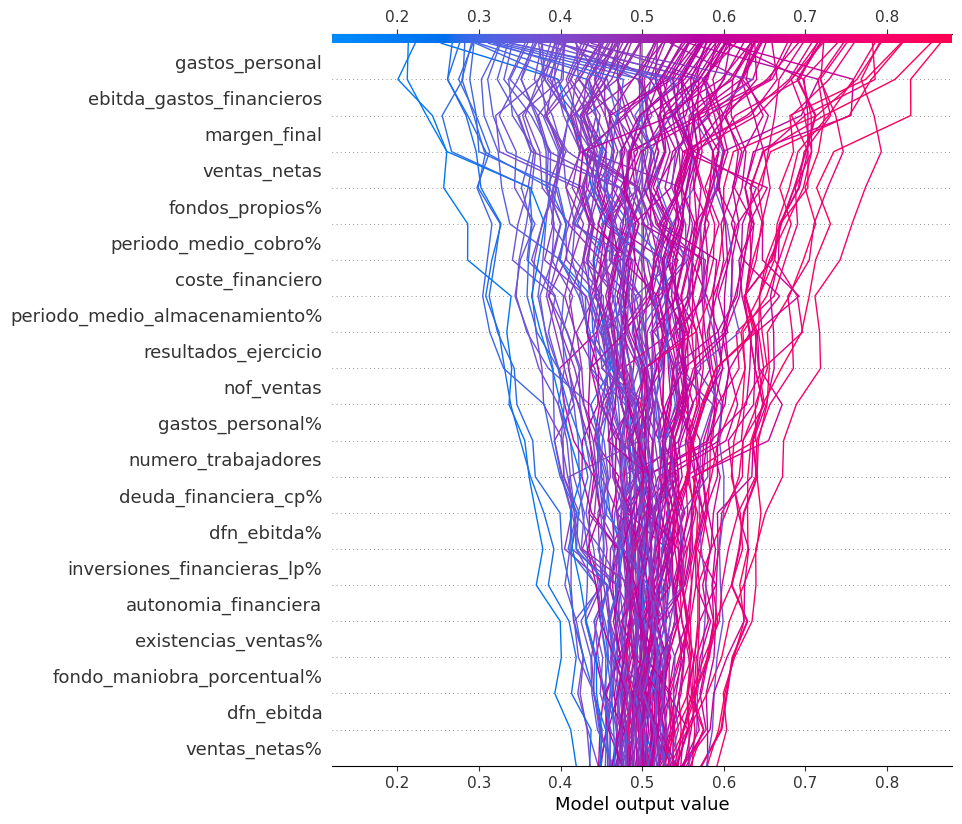

In [17]:
shap.decision_plot(
    explainer.expected_value[1],       # Clase 1
    shap_values[1],              # Todas las muestras para clase 1
    X_test_df                          # Features originales
)


Este gráfico corresponde al SHAP decision plot, una herramienta visual muy poderosa que permite entender cómo las variables van acumulando impacto en la predicción final del modelo Random Forest para múltiples observaciones. Cada línea representa el recorrido de una muestra desde el valor base hasta su predicción final, mostrando cómo cada variable va sumando o restando probabilidad de clasificación como riesgo alto.

En el eje horizontal se encuentra el valor final de salida del modelo (model output value), es decir, la probabilidad estimada de que la empresa sea clasificada como riesgosa (clase 1). En el eje vertical aparecen las variables ordenadas de mayor a menor importancia promedio, con gastos_personal, ebitda_gastos_financieros y margen_final encabezando la lista. Esto confirma los resultados de los summary plots anteriores.

Lo interesante de este gráfico es que permite observar cómo cambia la predicción de cada observación a medida que se van acumulando los efectos SHAP de cada variable. Las líneas que se inclinan hacia la derecha representan observaciones que terminan con alta probabilidad de riesgo (color fucsia), mientras que las que se desvían hacia la izquierda indican empresas que el modelo considera de bajo riesgo (color azul).

Se puede notar, por ejemplo, que gastos_personal es una variable muy influyente y muchas líneas ya comienzan a separarse desde su efecto inicial. De igual forma, ebitda_gastos_financieros y margen_final provocan desplazamientos relevantes en la predicción, lo que demuestra su rol crítico en el modelo. A medida que se agregan variables menos influyentes, como existencias_ventas% o ventas_netas%, el cambio marginal en las trayectorias es menor.

En resumen, este gráfico no solo valida la importancia de ciertas variables clave, sino que también muestra de manera intuitiva cómo cada observación es afectada por la acumulación de los impactos SHAP, lo cual es esencial para interpretar el comportamiento global del modelo en escenarios reales de evaluación de riesgo.

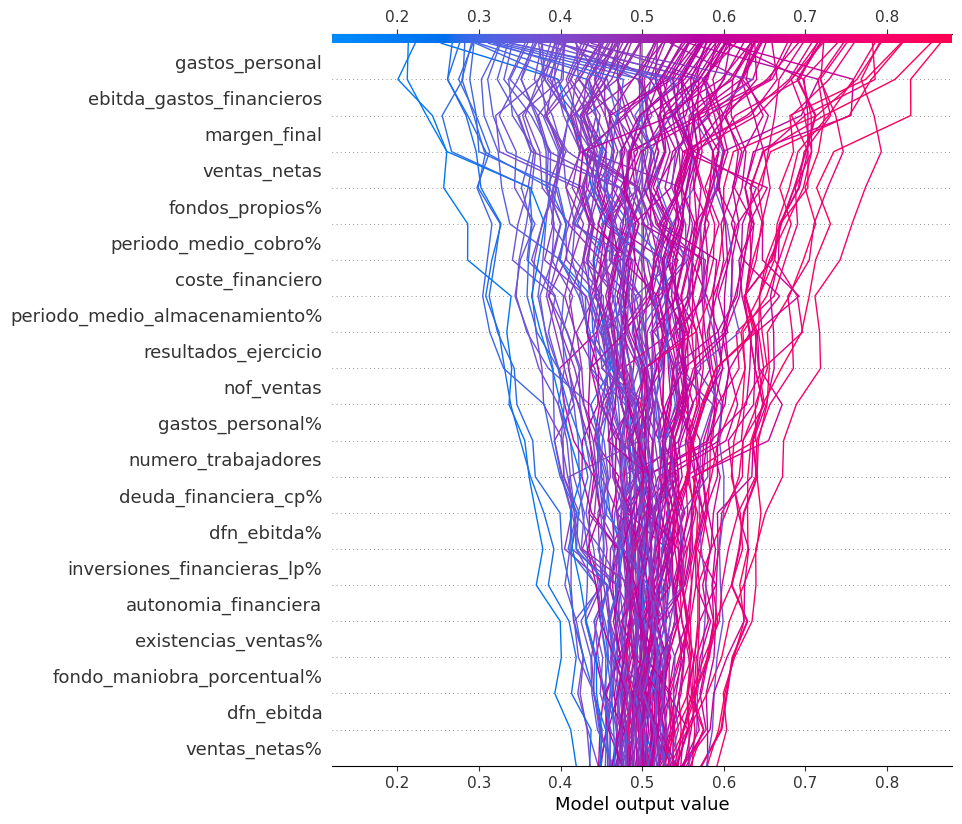

In [19]:
# Una sola muestra (ejemplo 0), clase 1
shap.decision_plot(
    explainer.expected_value[1],
    shap_values[1],
    X_test_df.iloc[0, :]
)


Este gráfico representa un SHAP decision plot para una única muestra del conjunto de prueba, específicamente para la clase 1, que en este caso se asocia con un riesgo crediticio alto (grade_code ≥ 7). El modelo utilizado es Random Forest, y la visualización nos permite entender con precisión cómo cada variable ha influido en la predicción individual de esta empresa.

En la parte inferior del gráfico se listan todas las características (features), y cada línea representa cómo estas contribuyen de forma acumulativa al valor de salida del modelo. El valor base (base value) es la predicción media del modelo para toda la muestra de entrenamiento, mientras que el punto final en la parte superior representa la probabilidad asignada por el modelo a esta observación específica de pertenecer a la clase 1.

Las variables están ordenadas según su impacto acumulado. En este ejemplo, observamos cómo gastos_personal, ebitda_gastos_financieros y margen_final incrementan la predicción hacia valores más altos, lo que sugiere que esta empresa presenta características típicas de riesgo elevado según estos indicadores. Por otro lado, otras variables como fondo_maniobra_porcentual% o dfn_ebitda tienen poco o ningún impacto en esta muestra concreta.

Esta forma de visualización es especialmente útil para auditoría, validación de modelos y explicación ante clientes o analistas, ya que muestra no solo el resultado, sino cómo se ha llegado a él. Además, aporta confianza en modelos opacos como los ensamblados de árboles, al proporcionar trazabilidad e interpretabilidad caso a caso.

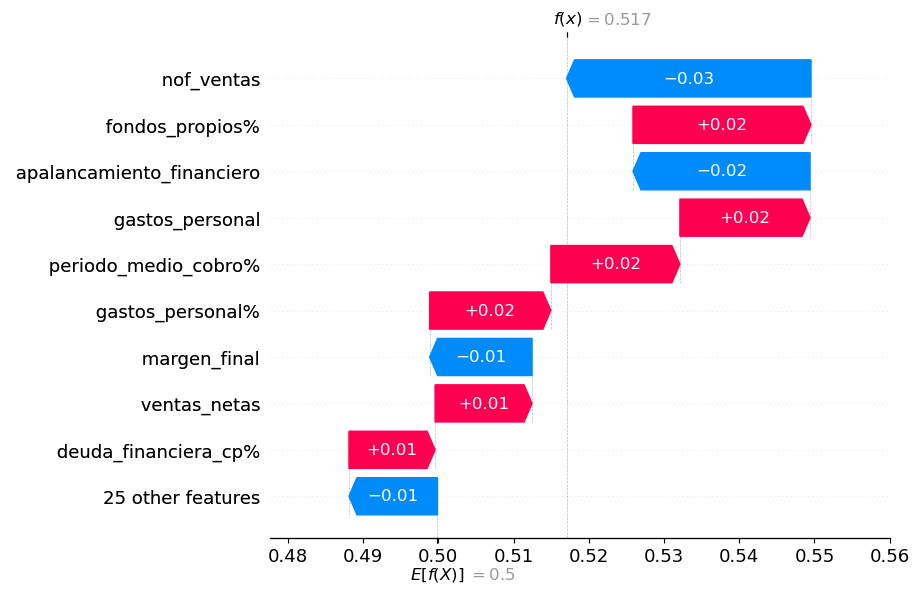

In [21]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[1],     # Valor esperado para clase 1
    shap_values[1][0],               # SHAP values de la muestra 0, clase 1
    X_test_df.iloc[0]                # Features de la muestra 0
)


Este gráfico tipo waterfall generado con SHAP representa de forma detallada cómo cada variable contribuyó a la predicción del modelo Random Forest para una única muestra, específicamente la probabilidad de pertenecer a la clase 1 (riesgo alto, nota > 7).

La predicción base del modelo, sin ninguna información adicional (el valor esperado), es 0.50. A partir de ahí, las variables con impacto positivo (en rojo) empujan la predicción hacia arriba, y las variables con impacto negativo (en azul), hacia abajo. Finalmente, la predicción concreta para esta muestra fue de 0.517, es decir, un ligero sesgo hacia riesgo alto.

Entre los factores que más empujan la predicción hacia arriba están:

- periodo_medio_cobro% (+0.02): un mayor tiempo en cobrar podría asociarse a mayor riesgo.

- gastos_personal y fondos_propios% (+0.02): sus valores en esta muestra aumentan la probabilidad de clasificación como clase 1.

Por otro lado, algunas variables compensan bajando esa probabilidad:

- nof_ventas (–0.03): un mayor número de ventas puede ser visto como signo de buena salud empresarial.

- apalancamiento_financiero (–0.02): en esta muestra, su valor reduce la probabilidad de riesgo, quizá por tratarse de una deuda controlada.

Este análisis permite explicar de forma clara qué factores concretos influyeron en la decisión del modelo, lo cual es especialmente importante en contextos de decisiones financieras y regulatorias.


### SHAP (MLP)

A continuación, comparamos los valores SHAP generados para dos modelos: Random Forest y MLP. Esto nos permite entender no solo su rendimiento cuantitativo, sino también las diferencias en las variables que consideran más determinantes para predecir riesgo alto. Esta comparación resulta crucial para elegir un modelo no solo preciso, sino también interpretable y alineado con la lógica de negocio.

Random Forest (RF) es un modelo basado en árboles de decisión. Construye muchos árboles independientes (cada uno con una muestra diferente del dataset y un subconjunto aleatorio de variables), y luego hace una votación para predecir. Cada árbol aprende reglas del tipo "si esta variable supera este valor, entonces la clase es...". Esta estructura jerárquica hace que sea más fácil interpretar qué variables tienen más influencia: podemos ver directamente cómo cada variable afecta las decisiones del modelo. Además, los modelos de árbol tienden a capturar bien relaciones no lineales y efectos de interacción simples, sin necesidad de normalizar los datos.

Por otro lado, MLP (Multi-Layer Perceptron) es una red neuronal densa que intenta aproximar funciones complejas mediante capas de neuronas conectadas entre sí. Cada neurona aplica una combinación lineal de las entradas, seguida de una función no lineal. A diferencia de Random Forest, el MLP no aprende reglas explícitas sino patrones abstractos en los datos, especialmente si hay relaciones no lineales o combinaciones complejas entre variables. Esta flexibilidad puede mejorar el rendimiento en ciertos contextos, pero también hace que su interpretación sea más difícil y más sensible a la escala y al preprocesamiento de datos.

Por eso, al aplicar SHAP, en Random Forest suele haber una relación más directa entre la importancia de una variable y su impacto en la predicción. En cambio, en MLP los SHAP values pueden parecer más “dispersos” o suaves, ya que las variables interactúan de forma más compleja. Además, SHAP en MLP requiere métodos como KernelExplainer, que son más lentos y aproximados, mientras que para Random Forest se puede usar TreeExplainer, mucho más rápido y preciso.

Eliminando por baja varianza: ['cash_flow_antes_var']
Eliminando por alta correlacion: []
Distribución de clase sintética:
target_bin
0    157
1    143
Name: count, dtype: int64


`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
100%|█████████████████████████████████████████| 152/152 [03:51<00:00,  1.52s/it]


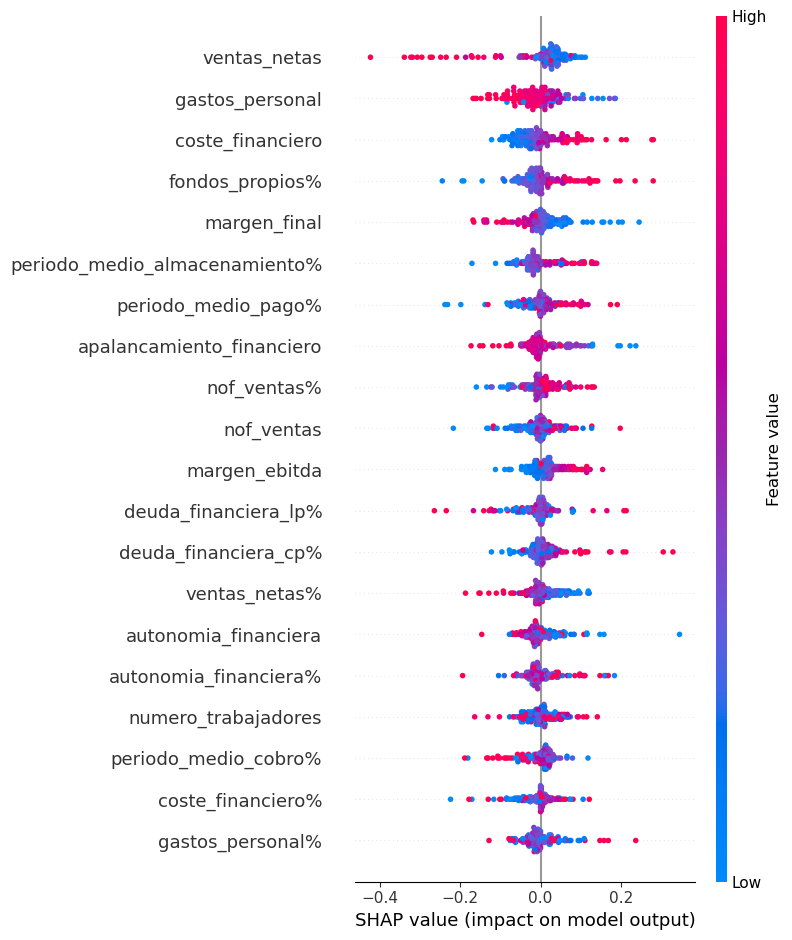

In [24]:
import shap
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

# Leer datos
df = pd.read_parquet("companies_T_anon.parquet")
df = preprocesar_datos(df)
df = seleccionar_variables(df, target_col="target_bin")

# Separar X e y
y = df["target_bin"]
X = df.drop(columns=["target_bin"])

# CTGAN
X_ctgan, y_ctgan = generar_datos_ctgan(X, y)

# SMOTE
X_ctgan_smote, y_ctgan_smote = SMOTE(random_state=42).fit_resample(X_ctgan, y_ctgan)

# Train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_ctgan_smote, y_ctgan_smote, test_size=0.2, stratify=y_ctgan_smote, random_state=42
)

X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Entrenar MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp.fit(X_train_df, y_train)

# SHAP con KernelExplainer
explainer = shap.KernelExplainer(mlp.predict_proba, shap.sample(X_train_df, 100, random_state=42))
shap_values = explainer.shap_values(X_test_df)

# Summary plot (clase 1)
shap.summary_plot(shap_values[1], X_test_df)


Este gráfico SHAP summary para el modelo MLP muestra cómo distintas variables financieras afectan las predicciones de riesgo para cada muestra. En este caso, los valores SHAP están centrados en 0 y distribuidos hacia la derecha (mayor riesgo) o hacia la izquierda (menor riesgo), y el color indica si el valor original de la variable era alto (rojo) o bajo (azul).

La variable ventas_netas es la más influyente, y se observa que valores bajos (en azul) tienden a reducir la probabilidad de riesgo, mientras que valores altos (rojos) pueden incrementarla, posiblemente por relación con mayor exposición financiera. Le siguen variables como gastos_personal y coste_financiero, donde también se aprecia una clara dispersión: altos gastos o costes tienden a incrementar el riesgo.

Es interesante que varias variables relacionadas con endeudamiento y rentabilidad (como apalancamiento_financiero, margen_ebitda, fondos_propios%) tienen una distribución de SHAP bastante centrada, indicando que su efecto depende mucho del contexto combinado con otras variables. Esto es típico en MLP, que puede modelar interacciones no lineales entre variables de manera más compleja que los modelos de árboles.

Por último, vemos que aunque muchas variables tienen un impacto moderado, su combinación permite al MLP construir una representación bastante rica y flexible del riesgo. Este tipo de análisis es crucial para identificar patrones sutiles y multifactoriales, y justificar por qué ciertos clientes son considerados más o menos riesgosos.

100%|█████████████████████████████████████████| 152/152 [00:16<00:00,  9.09it/s]


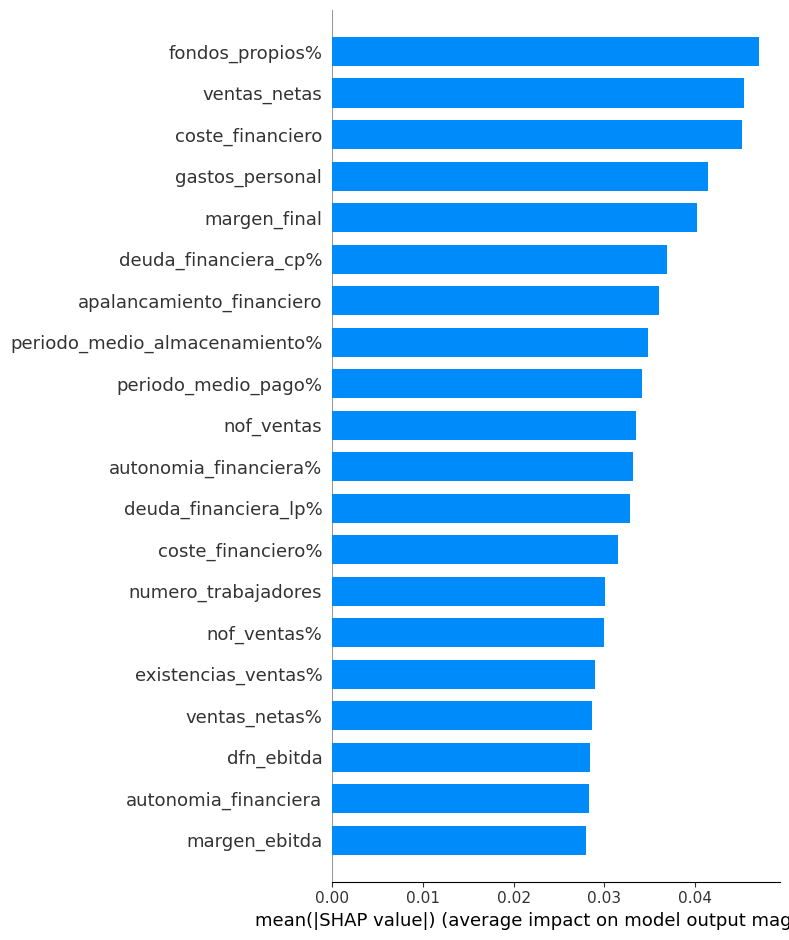

In [25]:
import shap

explainer = shap.KernelExplainer(mlp.predict_proba, shap.sample(X_train, 100))
shap_values = explainer.shap_values(X_test_df, nsamples=100)

# Para clasificación binaria:
shap.summary_plot(shap_values[1], X_test_df, plot_type="bar")


Este gráfico SHAP tipo bar plot para el modelo MLP resume la importancia media de cada variable en la predicción del riesgo crediticio, usando el valor medio absoluto de SHAP (mean(|SHAP value|)) para cada característica. En este tipo de visualización no se distingue dirección (positivo o negativo), sino solo magnitud del impacto.

En primer lugar, destacan fondos_propios% y ventas_netas como las variables más influyentes. Esto indica que la red neuronal da mucho peso a la estructura financiera propia de la empresa y a su volumen de ventas, lo cual es coherente con criterios tradicionales de solvencia. El coste financiero y los gastos personales también tienen gran relevancia, mostrando que el modelo considera tanto los ingresos como los gastos para evaluar el riesgo.

Otros indicadores importantes son el margen_final y la deuda financiera cp%, lo que refleja atención al beneficio neto y al compromiso de pago a corto plazo. Variables como el apalancamiento financiero, periodo medio de almacenamiento o el periodo medio de pago también aparecen en la parte alta, lo que sugiere que el MLP está captando aspectos operativos clave que pueden afectar la liquidez.

En comparación con modelos más simples, el MLP parece aprovechar un mayor número de variables de forma más equilibrada, sin depender excesivamente de una sola. Este patrón sugiere que el modelo capta relaciones no lineales y combinaciones entre muchas variables, lo que le da una ventaja en contextos complejos como este, con datos generados y balanceados artificialmente.


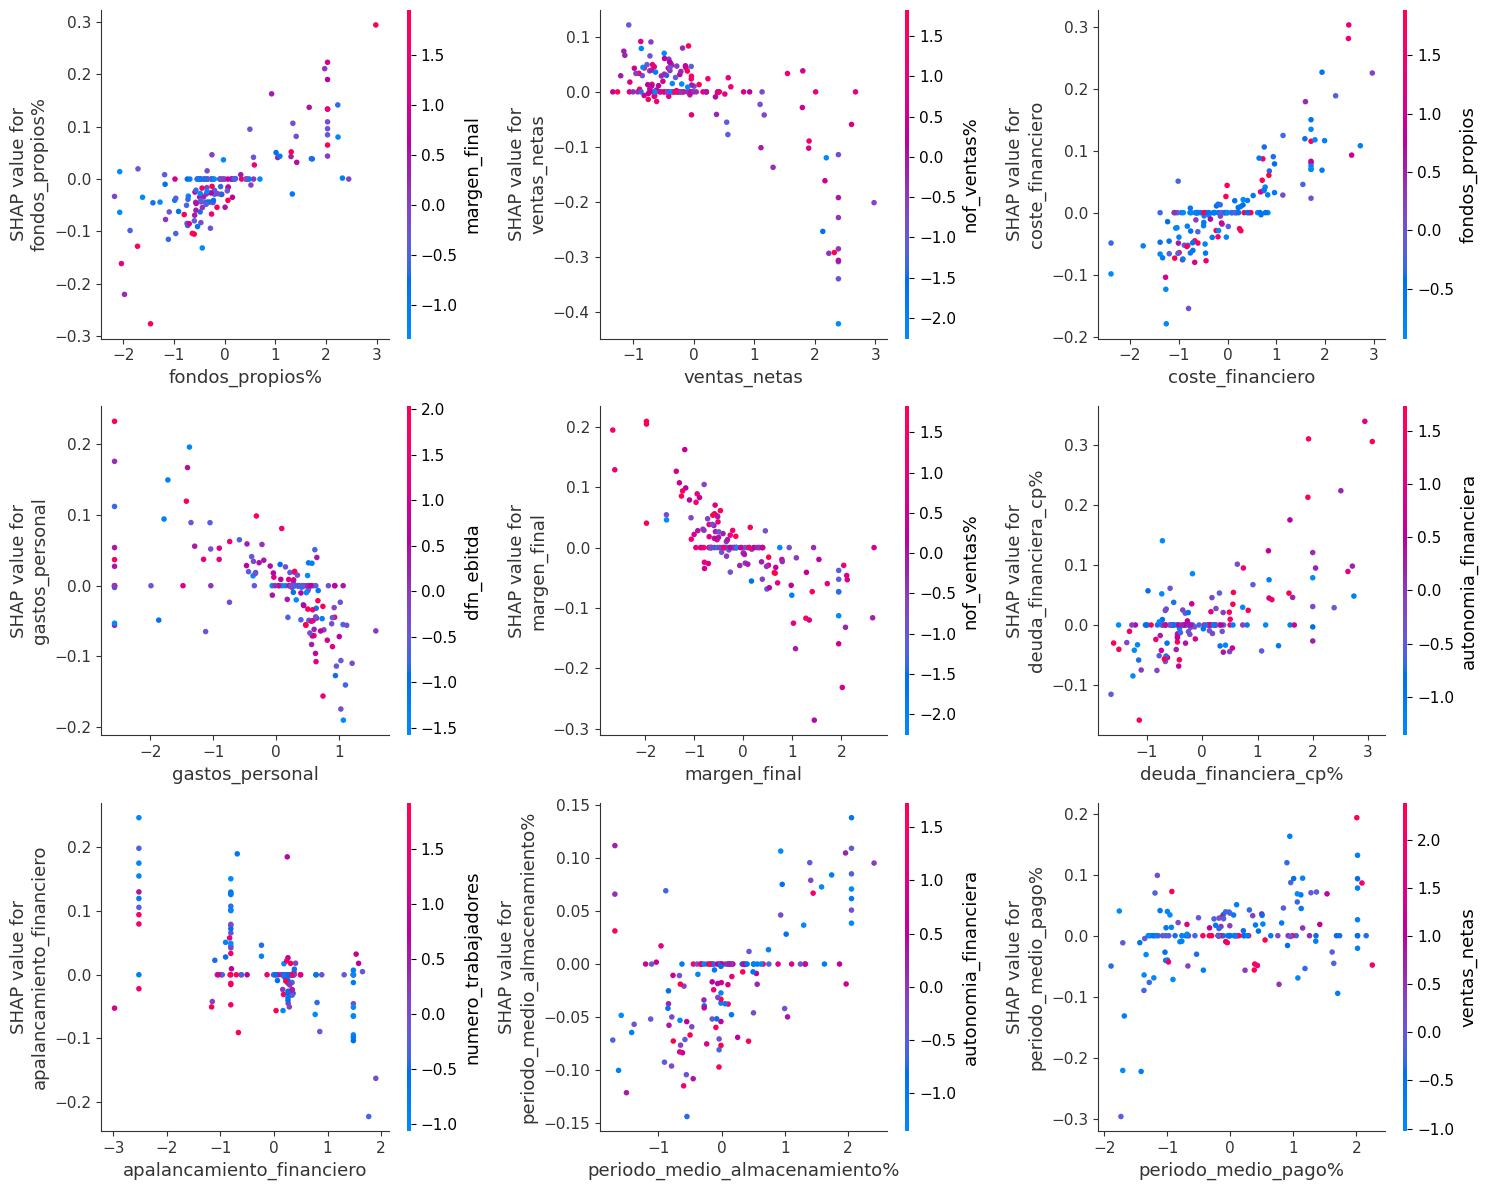

In [26]:
# Número de variables a mostrar
n_features = 9
shap_vals_class1 = shap_values[1]  # SHAP para clase positiva
top_features = np.argsort(np.abs(shap_vals_class1).mean(0))[-n_features:][::-1]
feature_names = X_test_df.columns[top_features]

# Crear subplots
cols = 3
rows = math.ceil(n_features / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()

for i, feature in enumerate(feature_names):
    shap.dependence_plot(
        feature,
        shap_vals_class1,
        X_test_df,
        ax=axes[i],
        show=False
    )

# Eliminar subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Este gráfico SHAP tipo dependence plot matrix del modelo MLP muestra cómo cada variable afecta la predicción de riesgo de forma individual y en relación con otra variable correlacionada (eje de color). Se puede observar que fondos_propios% tiene una relación positiva clara: a medida que aumentan los fondos propios, el valor SHAP también sube, indicando menor riesgo (recordando que el modelo predice clase 1 = riesgo alto, por tanto, valores SHAP negativos alejan del riesgo).

En el caso de ventas_netas, se ve un patrón menos lineal, pero en general las ventas bajas se asocian con SHAP negativos (reduciendo el riesgo), mientras que ventas más altas muestran mayor dispersión, sugiriendo interacciones con otras variables. Coste financiero y gastos_personal también presentan patrones ascendentes, donde mayores costes parecen aumentar la probabilidad de riesgo, aunque con cierta variabilidad.

La variable margen_final muestra un efecto decreciente: a mayor margen, menor impacto en la clase de riesgo, lo que tiene sentido ya que mejores márgenes indican empresas más rentables. Similar comportamiento se ve en autonomía financiera y apalancamiento financiero, aunque este último presenta un efecto menos claro y más disperso, lo que sugiere que MLP puede estar utilizando su interacción con otras variables más que su efecto aislado.

Finalmente, variables como periodo_medio_pago% y deuda_financiera_cp% presentan relaciones más planas, lo que podría indicar menor peso en la decisión individual o dependencia más fuerte de interacciones con otras variables. En resumen, MLP capta relaciones complejas y no necesariamente lineales, y su análisis SHAP revela combinaciones ricas de interacciones que van más allá de los efectos simples que podrían captarse con modelos lineales o de árbol.


In [29]:
shap.initjs()
shap.force_plot(
    explainer.expected_value[1],     # Valor esperado para clase 1
    shap_values[1][0],               # SHAP values de la fila 0, clase 1
    X_test_df.iloc[0]                # Mismos features de esa fila
)


Este gráfico SHAP tipo force plot generado para el modelo MLP muestra cómo los diferentes atributos financieros de una empresa afectan la predicción individual del riesgo crediticio. En este caso, el modelo predice un riesgo más bajo gracias a una combinación de factores que empujan la predicción hacia la derecha (valores en azul) y contrarrestan parcialmente aquellos que la empujan hacia la izquierda (valores en rojo).

Las variables que incrementan la probabilidad de riesgo (color rojo) son, principalmente: dfn_ebitda, inversiones_financieras_lp% y periodo_medio_cobro%. Estos tres factores reflejan situaciones potencialmente críticas: una relación deuda/EBITDA elevada, una gran proporción de inversiones a largo plazo (menos liquidez) y un tiempo de cobro excesivo que puede comprometer el flujo de caja.

Por el contrario, las variables que reducen el riesgo (en azul) como apalancamiento_financiero, fondos_propios% y periodo_medio_almacenamiento%, ayudan a compensar los riesgos anteriores. En particular, un buen nivel de fondos propios y una gestión adecuada del apalancamiento actúan como factores protectores.

Este gráfico permite ver de manera visual y clara cómo el modelo de red neuronal pondera múltiples entradas y genera una predicción personalizada, mostrando la interacción de múltiples indicadores contables de forma transparente. Esta capacidad explicativa es crucial para que analistas financieros puedan confiar y validar las decisiones automáticas del modelo.


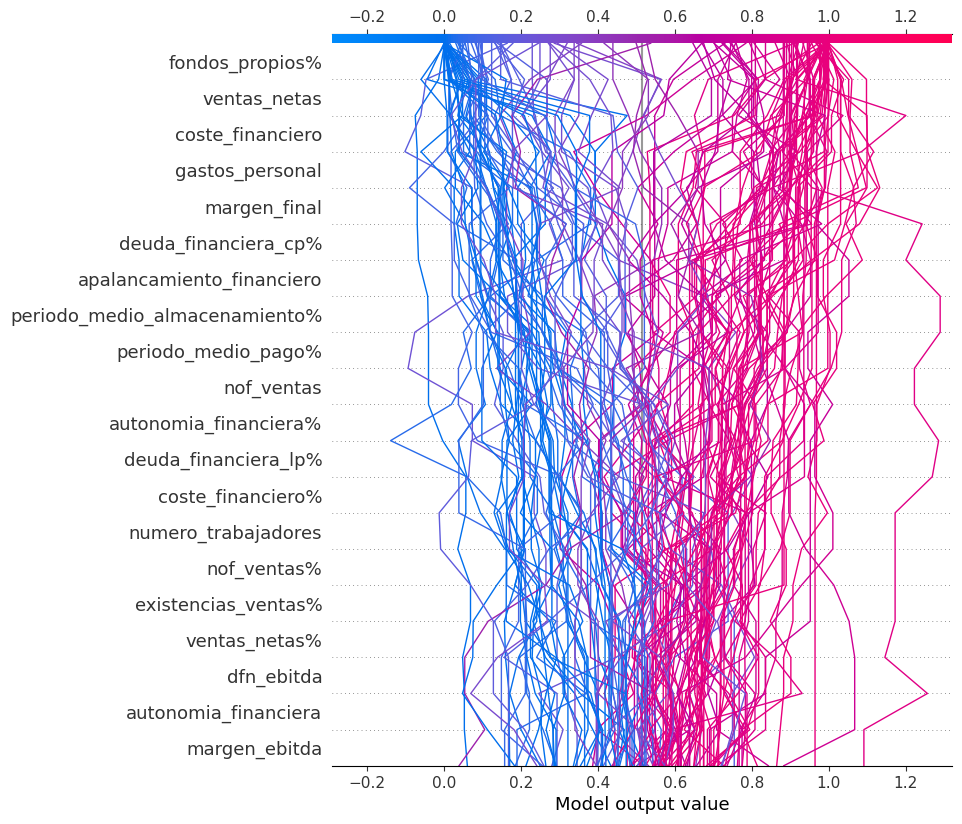

In [30]:
shap.decision_plot(
    explainer.expected_value[1],   # Para clase 1
    shap_values[1],                # SHAP values para clase 1 (forma: [n_samples, n_features])
    X_test_df                      # Features
)


Este gráfico tipo decision plot generado con SHAP para el modelo MLP muestra cómo evoluciona la predicción del modelo desde el valor base (promedio) hasta la salida final para cada observación. Las líneas representan casos individuales, y el eje horizontal muestra el valor de salida del modelo, es decir, la probabilidad predicha de que una empresa tenga riesgo alto (clase 1). Cuanto más a la derecha, mayor riesgo predicho.

En el eje vertical se presentan las variables en orden de importancia acumulada según su influencia media en la predicción. Las primeras características, como fondos_propios%, ventas_netas, coste_financiero y gastos_personal, tienen mayor peso en el desplazamiento de las curvas, lo que indica que son clave para la decisión del modelo.

Las líneas azules representan trayectorias de observaciones que el modelo predice con baja probabilidad de riesgo (valores cercanos a 0), mientras que las fucsia (rosas) muestran casos con alta probabilidad (valores cercanos o superiores a 1). La dispersión y cruce de líneas indican interacciones complejas entre variables: el mismo valor de una característica puede tener efectos distintos dependiendo del resto de inputs. Esto es típico de redes neuronales como el MLP, que capturan relaciones no lineales de forma más rica que modelos como Random Forest.

Este tipo de visualización es especialmente útil para auditar modelos de caja negra como el MLP, permitiendo ver no solo qué variables influyen, sino cómo lo hacen en distintos perfiles de empresa.


# Conclusión

| Aspecto                           | Conclusión                                                                                                                                              |
|----------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Rendimiento general**          | El modelo MLP obtuvo el mejor F1-score (0.77) sobre los datos generados con CTGAN + SMOTE, lo que demuestra su capacidad en entornos con small data.   |
| **Interpretabilidad con SHAP**   | SHAP permite visualizar cómo cada variable influye en la predicción. En RF el impacto es más claro y directo, mientras que en MLP depende de interacciones. |
| **Importancia de los %**         | Las variables en porcentaje reflejan cambios relativos y son clave para captar dinámicas empresariales relevantes en la predicción de riesgo.          |
| **Recomendación final**          | Si se busca rendimiento y se cuenta con datos enriquecidos, se recomienda MLP. Si se requiere explicabilidad, Random Forest es más adecuado.          |


El análisis comparativo entre los modelos Random Forest (RF) y Multi-Layer Perceptron (MLP) evidencia diferencias tanto en rendimiento como en interpretabilidad. En términos de precisión, el MLP entrenado sobre datos enriquecidos mediante CTGAN y SMOTE obtuvo el mejor F1-score (0.77), lo que confirma que la combinación de generación de datos sintéticos y redes neuronales profundas puede mejorar significativamente el rendimiento en contextos con datos desbalanceados y limitados.

A nivel metodológico, los dos modelos funcionan de manera muy distinta. Random Forest toma decisiones a partir de reglas claras construidas mediante árboles de decisión, lo que facilita su interpretación directa. En cambio, el MLP aprende a partir de combinaciones no lineales de las variables, lo que le permite capturar patrones complejos, pero a costa de una mayor dificultad interpretativa. En este contexto, el uso de SHAP (SHapley Additive exPlanations) ha sido clave para poder explicar las decisiones de ambos modelos y entender cómo cada variable contribuye a las predicciones de riesgo.

Los gráficos de SHAP muestran que variables como ventas_netas, fondos_propios%, coste_financiero y gastos_personal son especialmente relevantes en ambos modelos, aunque su efecto es más nítido y directo en el caso de Random Forest. En el MLP, estas variables interactúan de forma más compleja, y el modelo tiende a utilizar más variables al mismo tiempo con distintos grados de influencia.

Una observación destacada es el valor añadido de las variables expresadas en porcentaje. Estas capturan variaciones relativas respecto a una base inicial (por ejemplo, evolución de gastos, deuda o márgenes), y han demostrado ser muy informativas para ambos modelos, ayudando a reflejar la salud y evolución financiera de las empresas.

En conclusión, la elección del modelo dependerá del equilibrio entre precisión y explicabilidad que se desee alcanzar. Si el objetivo principal es maximizar el rendimiento predictivo y se dispone de datos generados o aumentados, el MLP es una excelente opción. No obstante, si se requiere una mayor transparencia en las decisiones, por ejemplo en entornos financieros regulados, Random Forest sigue siendo una alternativa robusta y explicable.